In [1]:
import os
from tempfile import tempdir
from time import time
from turtle import color
from unittest.mock import NonCallableMagicMock
import pandas as pd
import numpy as np
import warnings
import math
import re

import seaborn as sns
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import tqdm
import importlib

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt
from copy import copy 

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.encapsulation.constant import Atoms
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import corems.lc_icpms_ftms.calc.lc_icrms_qc_assign as icrms
import corems.lc_icpms_ftms.calc.lc_icrms_helpers as lcmsfns

import importlib
dir='/Volumes/Samsung_T5/NHMFL/2023_January_Christian/wastewater/Zorbax_5um_inject_1500ms/neg'
flist=os.listdir(dir)
os.chdir(dir)

In [2]:
# get files & parsers

dir='/Volumes/Samsung_T5/NHMFL/2023_January_Christian/wastewater/Zorbax_5um_inject_1500ms/neg'
flist=os.listdir(dir)
os.chdir(dir)

# get parsers

MSfiles={}

for f in flist:
    if ('.raw' in f) & ('._' not in f) :
        print(f)
        parser = rawFileReader.ImportMassSpectraThermoMSFileReader(f)
        MSfiles[f]={'parser': parser}

data = icrms.lc_icr_assign(dir)

data.master_data_holder = MSfiles

data._raw_filelist = data.master_data_holder.keys()

20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_qh2o_300_500_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_qh2o_300_500_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_300_500_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_300_500_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_qh2o_fullmz_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_qh2o_fullmz_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_fullmz_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_300_500_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_300_500_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_fullmz_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_fullmz_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_fullmz_01.raw


In [4]:
# set assignment parameters
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.25
MSParameters.molecular_search.max_ppm_error = 0.25

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,3)
MSParameters.molecular_search.usedAtoms['I'] = (0,0)
MSParameters.molecular_search.usedAtoms['F'] = (0,4)
MSParameters.molecular_search.usedAtoms['Cl'] = (0,0)
MSParameters.molecular_search.usedAtoms['S'] = (0,1)


In [5]:
# run assignment algorithm
timerange = [4,24]  # start (min) to stop (min)
interval = 2  # min 
refmasslist = "/Users/christiandewey/CoreMS/db/Hawkes_neg.ref"

data.assign_formula(interval = interval, timerange = timerange, 
    refmasslist = refmasslist, calorder =2, charge = 1, cal_ppm_threshold= (0,3))

data_df = data.complete_results_df



20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_qh2o_300_500_02.raw
1 of 12 files
timestart: 4
negative
MS Obj loaded - 268 peaks found.
MS Obj loaded - 268 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
64 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.060 ppm
minimize function performed 363 fn evals and 7 iterations
'runworker'  48.00 ms


Loading molecular formula database: 244178it [00:05, 43503.41it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 578.99it/s]
Loading molecular formula database: 247740it [00:05, 43199.38it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 860.81it/s] 
Loading molecular formula database: 166880it [00:04, 39814.87it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 832.28it/s]


'run_molecular_formula'  16801.04 ms
173 assigned peaks and 95 unassigned peaks, total  = 64.55 %, relative abundance = 62.36 %, RMS error (best candidate) (ppm) = 0.070
timestart: 6
negative
MS Obj loaded - 295 peaks found.
MS Obj loaded - 295 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
89 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.062 ppm
minimize function performed 352 fn evals and 7 iterations
'runworker'  32.07 ms


Loading molecular formula database: 244178it [00:05, 42369.56it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 577.84it/s]
Loading molecular formula database: 247740it [00:06, 41059.47it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 801.95it/s] 
Loading molecular formula database: 166880it [00:04, 41570.44it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 819.93it/s]


'run_molecular_formula'  17067.97 ms
209 assigned peaks and 86 unassigned peaks, total  = 70.85 %, relative abundance = 68.52 %, RMS error (best candidate) (ppm) = 0.072
timestart: 8
negative
MS Obj loaded - 352 peaks found.
MS Obj loaded - 352 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
98 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.062 ppm
minimize function performed 357 fn evals and 7 iterations
'runworker'  31.58 ms


Loading molecular formula database: 244178it [00:05, 44356.77it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 514.75it/s]
Loading molecular formula database: 247740it [00:06, 39928.88it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 706.06it/s] 
Loading molecular formula database: 166880it [00:04, 38506.71it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 825.66it/s]


'run_molecular_formula'  17416.64 ms
246 assigned peaks and 106 unassigned peaks, total  = 69.89 %, relative abundance = 72.08 %, RMS error (best candidate) (ppm) = 0.067
timestart: 10
negative
MS Obj loaded - 368 peaks found.
MS Obj loaded - 368 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
106 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.066 ppm
minimize function performed 320 fn evals and 6 iterations
'runworker'  31.11 ms


Loading molecular formula database: 244178it [00:05, 43683.33it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 478.18it/s]
Loading molecular formula database: 247740it [00:06, 38506.17it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 677.87it/s]
Loading molecular formula database: 166880it [00:04, 38871.16it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 730.03it/s]


'run_molecular_formula'  17788.40 ms
273 assigned peaks and 95 unassigned peaks, total  = 74.18 %, relative abundance = 74.88 %, RMS error (best candidate) (ppm) = 0.066
timestart: 12
negative
MS Obj loaded - 353 peaks found.
MS Obj loaded - 353 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
101 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.054 ppm
minimize function performed 352 fn evals and 7 iterations
'runworker'  32.66 ms


Loading molecular formula database: 244178it [00:06, 40622.50it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 514.00it/s]
Loading molecular formula database: 247740it [00:06, 39822.18it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 696.91it/s] 
Loading molecular formula database: 166880it [00:03, 43688.77it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 763.38it/s]


'run_molecular_formula'  17457.64 ms
269 assigned peaks and 84 unassigned peaks, total  = 76.20 %, relative abundance = 76.11 %, RMS error (best candidate) (ppm) = 0.066
timestart: 14
negative
MS Obj loaded - 442 peaks found.
MS Obj loaded - 442 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
97 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.071 ppm
minimize function performed 317 fn evals and 6 iterations
'runworker'  32.11 ms


Loading molecular formula database: 244178it [00:05, 41820.85it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 428.44it/s]
Loading molecular formula database: 247740it [00:06, 39384.29it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 579.65it/s]
Loading molecular formula database: 166880it [00:04, 41074.49it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 695.95it/s]


'run_molecular_formula'  17831.33 ms
310 assigned peaks and 132 unassigned peaks, total  = 70.14 %, relative abundance = 71.68 %, RMS error (best candidate) (ppm) = 0.077
timestart: 16
negative
MS Obj loaded - 397 peaks found.
MS Obj loaded - 397 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
92 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.052 ppm
minimize function performed 350 fn evals and 7 iterations
'runworker'  77.19 ms


Loading molecular formula database: 244178it [00:06, 39454.48it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 475.86it/s]
Loading molecular formula database: 247740it [00:05, 42123.56it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 640.91it/s]
Loading molecular formula database: 166880it [00:04, 39243.79it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 772.48it/s]


'run_molecular_formula'  17854.63 ms
283 assigned peaks and 114 unassigned peaks, total  = 71.28 %, relative abundance = 73.35 %, RMS error (best candidate) (ppm) = 0.069
timestart: 18
negative
MS Obj loaded - 382 peaks found.
MS Obj loaded - 382 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
78 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.050 ppm
minimize function performed 357 fn evals and 7 iterations
'runworker'  31.15 ms


Loading molecular formula database: 244178it [00:05, 42573.57it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 383.76it/s]
Loading molecular formula database: 247740it [00:06, 40098.67it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 516.07it/s]
Loading molecular formula database: 166880it [00:04, 37405.55it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 723.07it/s]


'run_molecular_formula'  18143.13 ms
274 assigned peaks and 108 unassigned peaks, total  = 71.73 %, relative abundance = 71.62 %, RMS error (best candidate) (ppm) = 0.078
timestart: 20
negative
MS Obj loaded - 401 peaks found.
MS Obj loaded - 401 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
71 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.064 ppm
minimize function performed 357 fn evals and 7 iterations
'runworker'  31.72 ms


Loading molecular formula database: 244178it [00:06, 40654.20it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 353.13it/s]
Loading molecular formula database: 247740it [00:05, 42246.86it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 632.51it/s]
Loading molecular formula database: 166880it [00:04, 36619.37it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 512.23it/s]


'run_molecular_formula'  18271.27 ms
270 assigned peaks and 131 unassigned peaks, total  = 67.33 %, relative abundance = 73.35 %, RMS error (best candidate) (ppm) = 0.079
timestart: 22
negative
MS Obj loaded - 226 peaks found.
MS Obj loaded - 226 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
39 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 390 fn evals and 8 iterations
'runworker'  30.40 ms


Loading molecular formula database: 244178it [00:05, 43374.01it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 698.16it/s]
Loading molecular formula database: 247740it [00:05, 43096.50it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 971.52it/s] 
Loading molecular formula database: 166880it [00:03, 44429.82it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 1080.25it/s]


'run_molecular_formula'  16170.38 ms
172 assigned peaks and 54 unassigned peaks, total  = 76.11 %, relative abundance = 76.19 %, RMS error (best candidate) (ppm) = 0.047


20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_qh2o_300_500_01.raw
2 of 12 files
timestart: 4
negative
MS Obj loaded - 295 peaks found.
MS Obj loaded - 295 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
79 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.058 ppm
minimize function performed 397 fn evals and 8 iterations
'runworker'  31.07 ms


Loading molecular formula database: 244178it [00:05, 42153.41it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 536.11it/s]
Loading molecular formula database: 247740it [00:05, 43305.22it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 831.35it/s] 
Loading molecular formula database: 166880it [00:03, 42823.14it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 860.26it/s]


'run_molecular_formula'  16676.73 ms
205 assigned peaks and 90 unassigned peaks, total  = 69.49 %, relative abundance = 67.51 %, RMS error (best candidate) (ppm) = 0.063
timestart: 6
negative
MS Obj loaded - 335 peaks found.
MS Obj loaded - 335 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
96 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.056 ppm
minimize function performed 355 fn evals and 7 iterations
'runworker'  31.54 ms


Loading molecular formula database: 244178it [00:05, 41049.97it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 522.11it/s]
Loading molecular formula database: 247740it [00:05, 43604.01it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 698.39it/s] 
Loading molecular formula database: 166880it [00:03, 42111.19it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 893.34it/s]


'run_molecular_formula'  16937.55 ms
252 assigned peaks and 83 unassigned peaks, total  = 75.22 %, relative abundance = 73.43 %, RMS error (best candidate) (ppm) = 0.067
timestart: 8
negative
MS Obj loaded - 297 peaks found.
MS Obj loaded - 297 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
94 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.041 ppm
minimize function performed 353 fn evals and 7 iterations
'runworker'  31.40 ms


Loading molecular formula database: 244178it [00:05, 41781.87it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 589.37it/s]
Loading molecular formula database: 247740it [00:05, 43842.59it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 765.54it/s] 
Loading molecular formula database: 166880it [00:04, 39585.78it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 980.81it/s]


'run_molecular_formula'  16931.79 ms
242 assigned peaks and 55 unassigned peaks, total  = 81.48 %, relative abundance = 77.39 %, RMS error (best candidate) (ppm) = 0.058
timestart: 10
negative
MS Obj loaded - 327 peaks found.
MS Obj loaded - 327 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
104 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.061 ppm
minimize function performed 318 fn evals and 6 iterations
'runworker'  32.86 ms


Loading molecular formula database: 244178it [00:05, 43679.11it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 531.96it/s]
Loading molecular formula database: 247740it [00:05, 41902.78it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 705.98it/s]
Loading molecular formula database: 166880it [00:04, 39606.25it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 904.24it/s]


'run_molecular_formula'  17047.06 ms
269 assigned peaks and 58 unassigned peaks, total  = 82.26 %, relative abundance = 81.36 %, RMS error (best candidate) (ppm) = 0.067
timestart: 12
negative
MS Obj loaded - 341 peaks found.
MS Obj loaded - 341 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
103 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.056 ppm
minimize function performed 349 fn evals and 7 iterations
'runworker'  31.33 ms


Loading molecular formula database: 244178it [00:05, 41302.35it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 528.78it/s]
Loading molecular formula database: 247740it [00:05, 43026.79it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 721.04it/s] 
Loading molecular formula database: 166880it [00:03, 42958.92it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 894.85it/s]


'run_molecular_formula'  16881.10 ms
278 assigned peaks and 63 unassigned peaks, total  = 81.52 %, relative abundance = 82.31 %, RMS error (best candidate) (ppm) = 0.062
timestart: 14
negative
MS Obj loaded - 353 peaks found.
MS Obj loaded - 353 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
98 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.046 ppm
minimize function performed 353 fn evals and 7 iterations
'runworker'  29.80 ms


Loading molecular formula database: 244178it [00:05, 42185.15it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 518.61it/s]
Loading molecular formula database: 247740it [00:06, 40665.81it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 690.11it/s] 
Loading molecular formula database: 166880it [00:03, 42402.04it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 869.33it/s]


'run_molecular_formula'  17175.57 ms
299 assigned peaks and 54 unassigned peaks, total  = 84.70 %, relative abundance = 81.05 %, RMS error (best candidate) (ppm) = 0.059
timestart: 16
negative
MS Obj loaded - 373 peaks found.
MS Obj loaded - 373 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
99 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.078 ppm
minimize function performed 320 fn evals and 6 iterations
'runworker'  30.86 ms


Loading molecular formula database: 244178it [00:06, 40355.50it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 500.70it/s]
Loading molecular formula database: 247740it [00:05, 42116.07it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 665.67it/s] 
Loading molecular formula database: 166880it [00:04, 41161.87it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 840.50it/s]


'run_molecular_formula'  17394.90 ms
294 assigned peaks and 79 unassigned peaks, total  = 78.82 %, relative abundance = 83.04 %, RMS error (best candidate) (ppm) = 0.067
timestart: 18
negative
MS Obj loaded - 431 peaks found.
MS Obj loaded - 431 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
88 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.060 ppm
minimize function performed 351 fn evals and 7 iterations
'runworker'  31.77 ms


Loading molecular formula database: 244178it [00:06, 40195.00it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 357.77it/s]
Loading molecular formula database: 247740it [00:06, 39817.93it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 604.08it/s]
Loading molecular formula database: 166880it [00:03, 43843.16it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 721.90it/s]


'run_molecular_formula'  17843.19 ms
310 assigned peaks and 121 unassigned peaks, total  = 71.93 %, relative abundance = 80.38 %, RMS error (best candidate) (ppm) = 0.077
timestart: 20
negative
MS Obj loaded - 413 peaks found.
MS Obj loaded - 413 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
87 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.065 ppm
minimize function performed 354 fn evals and 7 iterations
'runworker'  30.24 ms


Loading molecular formula database: 244178it [00:05, 41214.18it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 365.35it/s]
Loading molecular formula database: 247740it [00:06, 38194.01it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 617.49it/s]
Loading molecular formula database: 166880it [00:03, 42126.39it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 636.19it/s]


'run_molecular_formula'  18121.00 ms
311 assigned peaks and 102 unassigned peaks, total  = 75.30 %, relative abundance = 81.29 %, RMS error (best candidate) (ppm) = 0.074
timestart: 22
negative
MS Obj loaded - 355 peaks found.
MS Obj loaded - 355 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
84 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.052 ppm
minimize function performed 353 fn evals and 7 iterations
'runworker'  31.33 ms


Loading molecular formula database: 244178it [00:05, 41045.33it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 428.88it/s]
Loading molecular formula database: 247740it [00:06, 40389.78it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 588.68it/s] 
Loading molecular formula database: 166880it [00:03, 42316.47it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 793.41it/s]


'run_molecular_formula'  17612.08 ms
290 assigned peaks and 65 unassigned peaks, total  = 81.69 %, relative abundance = 80.62 %, RMS error (best candidate) (ppm) = 0.061


20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_300_500_02.raw
3 of 12 files
timestart: 4
negative
MS Obj loaded - 595 peaks found.
MS Obj loaded - 595 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
111 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.037 ppm
minimize function performed 360 fn evals and 7 iterations
'runworker'  29.94 ms


Loading molecular formula database: 244178it [00:06, 39001.66it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 329.11it/s]
Loading molecular formula database: 247740it [00:05, 41354.76it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 449.04it/s]
Loading molecular formula database: 166880it [00:04, 40710.96it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 544.74it/s]


'run_molecular_formula'  18424.67 ms
554 assigned peaks and 41 unassigned peaks, total  = 93.11 %, relative abundance = 95.84 %, RMS error (best candidate) (ppm) = 0.048
timestart: 6
negative
MS Obj loaded - 700 peaks found.
MS Obj loaded - 700 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
109 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.040 ppm
minimize function performed 362 fn evals and 7 iterations
'runworker'  29.24 ms


Loading molecular formula database: 244178it [00:05, 40760.06it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 293.23it/s]
Loading molecular formula database: 247740it [00:06, 38980.69it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 407.34it/s]
Loading molecular formula database: 166880it [00:03, 41834.62it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 437.40it/s]


'run_molecular_formula'  18677.04 ms
655 assigned peaks and 45 unassigned peaks, total  = 93.57 %, relative abundance = 95.50 %, RMS error (best candidate) (ppm) = 0.045
timestart: 8
negative
MS Obj loaded - 461 peaks found.
MS Obj loaded - 461 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
84 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.031 ppm
minimize function performed 355 fn evals and 7 iterations
'runworker'  30.10 ms


Loading molecular formula database: 244178it [00:06, 39099.25it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 269.01it/s]
Loading molecular formula database: 247740it [00:06, 38443.74it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 490.33it/s]
Loading molecular formula database: 166880it [00:03, 45900.83it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 555.04it/s]


'run_molecular_formula'  18536.88 ms
426 assigned peaks and 35 unassigned peaks, total  = 92.41 %, relative abundance = 68.22 %, RMS error (best candidate) (ppm) = 0.046
timestart: 10
negative
MS Obj loaded - 657 peaks found.
MS Obj loaded - 657 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
110 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.039 ppm
minimize function performed 352 fn evals and 7 iterations
'runworker'  29.30 ms


Loading molecular formula database: 244178it [00:06, 38706.51it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 203.74it/s]
Loading molecular formula database: 247740it [00:06, 35898.71it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 392.80it/s]
Loading molecular formula database: 166880it [00:03, 43384.10it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 502.43it/s]


'run_molecular_formula'  19825.97 ms
616 assigned peaks and 41 unassigned peaks, total  = 93.76 %, relative abundance = 96.09 %, RMS error (best candidate) (ppm) = 0.047
timestart: 12
negative
MS Obj loaded - 1045 peaks found.
MS Obj loaded - 1045 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
124 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.133 ppm
minimize function performed 313 fn evals and 6 iterations
'runworker'  29.96 ms


Loading molecular formula database: 244178it [00:06, 36182.20it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 114.54it/s]
Loading molecular formula database: 247740it [00:06, 38845.58it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 233.01it/s]
Loading molecular formula database: 166880it [00:04, 38426.71it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 250.85it/s]


'run_molecular_formula'  22319.34 ms
869 assigned peaks and 176 unassigned peaks, total  = 83.16 %, relative abundance = 95.18 %, RMS error (best candidate) (ppm) = 0.062
timestart: 14
negative
MS Obj loaded - 689 peaks found.
MS Obj loaded - 689 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
103 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.147 ppm
minimize function performed 314 fn evals and 6 iterations
'runworker'  37.09 ms


Loading molecular formula database: 244178it [00:06, 39441.53it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 173.04it/s]
Loading molecular formula database: 247740it [00:06, 35908.98it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 423.75it/s]
Loading molecular formula database: 166880it [00:03, 43202.99it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 448.16it/s]


'run_molecular_formula'  19983.62 ms
632 assigned peaks and 57 unassigned peaks, total  = 91.73 %, relative abundance = 97.64 %, RMS error (best candidate) (ppm) = 0.047
timestart: 16
negative
MS Obj loaded - 619 peaks found.
MS Obj loaded - 619 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
102 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.133 ppm
minimize function performed 314 fn evals and 6 iterations
'runworker'  29.14 ms


Loading molecular formula database: 244178it [00:06, 39294.29it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 192.97it/s]
Loading molecular formula database: 247740it [00:06, 35908.15it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 453.48it/s]
Loading molecular formula database: 166880it [00:04, 41105.99it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 527.27it/s]


'run_molecular_formula'  19905.33 ms
587 assigned peaks and 32 unassigned peaks, total  = 94.83 %, relative abundance = 98.39 %, RMS error (best candidate) (ppm) = 0.039
timestart: 18
negative
MS Obj loaded - 1073 peaks found.
MS Obj loaded - 1073 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
119 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.104 ppm
minimize function performed 314 fn evals and 6 iterations
'runworker'  29.61 ms


Loading molecular formula database: 244178it [00:06, 37664.72it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 114.82it/s]
Loading molecular formula database: 247740it [00:06, 37414.65it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 265.65it/s]
Loading molecular formula database: 166880it [00:04, 36299.95it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 268.13it/s]


'run_molecular_formula'  22336.89 ms
903 assigned peaks and 170 unassigned peaks, total  = 84.16 %, relative abundance = 96.71 %, RMS error (best candidate) (ppm) = 0.058
timestart: 20
negative
MS Obj loaded - 861 peaks found.
MS Obj loaded - 861 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
106 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.094 ppm
minimize function performed 314 fn evals and 6 iterations
'runworker'  29.45 ms


Loading molecular formula database: 244178it [00:06, 37754.19it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 123.41it/s]
Loading molecular formula database: 247740it [04:49, 855.01it/s]  
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 343.97it/s]
Loading molecular formula database: 166880it [00:04, 41575.63it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 379.80it/s]


'run_molecular_formula'  304207.96 ms
761 assigned peaks and 100 unassigned peaks, total  = 88.39 %, relative abundance = 97.50 %, RMS error (best candidate) (ppm) = 0.051
timestart: 22
negative
MS Obj loaded - 779 peaks found.
MS Obj loaded - 779 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
108 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.110 ppm
minimize function performed 315 fn evals and 6 iterations
'runworker'  28.81 ms


Loading molecular formula database: 244178it [00:06, 37395.63it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 173.10it/s]
Loading molecular formula database: 247740it [00:06, 39815.74it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 354.35it/s]
Loading molecular formula database: 166880it [00:04, 36170.37it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 352.44it/s]


'run_molecular_formula'  20652.39 ms
700 assigned peaks and 79 unassigned peaks, total  = 89.86 %, relative abundance = 97.21 %, RMS error (best candidate) (ppm) = 0.060


20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_300_500_01.raw
4 of 12 files
timestart: 4
negative
MS Obj loaded - 746 peaks found.
MS Obj loaded - 746 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
119 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.040 ppm
minimize function performed 358 fn evals and 7 iterations
'runworker'  28.89 ms


Loading molecular formula database: 244178it [00:05, 42215.12it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [12:59<00:00,  2.60s/it]
Loading molecular formula database: 247740it [00:06, 37652.65it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 353.26it/s]
Loading molecular formula database: 166880it [00:04, 36268.78it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 418.65it/s]


'run_molecular_formula'  797824.84 ms
674 assigned peaks and 72 unassigned peaks, total  = 90.35 %, relative abundance = 95.32 %, RMS error (best candidate) (ppm) = 0.053
timestart: 6
negative
MS Obj loaded - 780 peaks found.
MS Obj loaded - 780 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
111 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.039 ppm
minimize function performed 353 fn evals and 7 iterations
'runworker'  29.88 ms


Loading molecular formula database: 244178it [00:05, 41790.52it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 262.81it/s]
Loading molecular formula database: 247740it [00:06, 38412.37it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 365.54it/s]
Loading molecular formula database: 166880it [00:04, 40891.45it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 399.43it/s]


'run_molecular_formula'  18968.74 ms
712 assigned peaks and 68 unassigned peaks, total  = 91.28 %, relative abundance = 94.77 %, RMS error (best candidate) (ppm) = 0.050
timestart: 8
negative
MS Obj loaded - 515 peaks found.
MS Obj loaded - 515 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
91 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.034 ppm
minimize function performed 363 fn evals and 7 iterations
'runworker'  29.91 ms


Loading molecular formula database: 244178it [00:06, 38924.40it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 249.98it/s]
Loading molecular formula database: 247740it [00:05, 41395.74it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 464.60it/s]
Loading molecular formula database: 166880it [00:03, 41942.71it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 534.54it/s]


'run_molecular_formula'  18591.78 ms
466 assigned peaks and 49 unassigned peaks, total  = 90.49 %, relative abundance = 67.98 %, RMS error (best candidate) (ppm) = 0.046
timestart: 10
negative
MS Obj loaded - 565 peaks found.
MS Obj loaded - 565 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
102 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.031 ppm
minimize function performed 356 fn evals and 7 iterations
'runworker'  29.46 ms


Loading molecular formula database: 244178it [00:06, 40224.80it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 243.28it/s]
Loading molecular formula database: 247740it [00:06, 38315.30it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 445.03it/s]
Loading molecular formula database: 166880it [00:04, 39576.64it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 581.59it/s]


'run_molecular_formula'  19141.71 ms
538 assigned peaks and 27 unassigned peaks, total  = 95.22 %, relative abundance = 96.28 %, RMS error (best candidate) (ppm) = 0.041
timestart: 12
negative
MS Obj loaded - 1102 peaks found.
MS Obj loaded - 1102 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
125 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.129 ppm
minimize function performed 316 fn evals and 6 iterations
'runworker'  29.27 ms


Loading molecular formula database: 244178it [00:06, 36649.59it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 108.02it/s]
Loading molecular formula database: 247740it [00:06, 37128.56it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 231.87it/s]
Loading molecular formula database: 166880it [00:04, 39391.19it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 245.87it/s]


'run_molecular_formula'  22601.70 ms
899 assigned peaks and 203 unassigned peaks, total  = 81.58 %, relative abundance = 95.17 %, RMS error (best candidate) (ppm) = 0.063
timestart: 14
negative
MS Obj loaded - 642 peaks found.
MS Obj loaded - 642 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
100 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.147 ppm
minimize function performed 314 fn evals and 6 iterations
'runworker'  29.61 ms


Loading molecular formula database: 244178it [00:06, 36918.89it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 186.89it/s]
Loading molecular formula database: 247740it [00:06, 38055.70it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 437.34it/s]
Loading molecular formula database: 166880it [00:04, 39291.63it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 479.54it/s]


'run_molecular_formula'  20214.84 ms
604 assigned peaks and 38 unassigned peaks, total  = 94.08 %, relative abundance = 98.16 %, RMS error (best candidate) (ppm) = 0.045
timestart: 16
negative
MS Obj loaded - 624 peaks found.
MS Obj loaded - 624 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
103 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.111 ppm
minimize function performed 314 fn evals and 6 iterations
'runworker'  30.09 ms


Loading molecular formula database: 244178it [00:06, 38282.63it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 204.58it/s]
Loading molecular formula database: 247740it [00:06, 39655.76it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 444.15it/s]
Loading molecular formula database: 166880it [00:04, 39798.62it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 522.59it/s]


'run_molecular_formula'  19479.49 ms
596 assigned peaks and 28 unassigned peaks, total  = 95.51 %, relative abundance = 98.50 %, RMS error (best candidate) (ppm) = 0.040
timestart: 18
negative
MS Obj loaded - 1041 peaks found.
MS Obj loaded - 1041 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
115 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.076 ppm
minimize function performed 315 fn evals and 6 iterations
'runworker'  78.80 ms


Loading molecular formula database: 244178it [00:06, 37970.42it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 111.24it/s]
Loading molecular formula database: 247740it [00:07, 34408.31it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 275.98it/s]
Loading molecular formula database: 166880it [00:04, 39588.67it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 283.28it/s]


'run_molecular_formula'  22533.28 ms
880 assigned peaks and 161 unassigned peaks, total  = 84.53 %, relative abundance = 97.15 %, RMS error (best candidate) (ppm) = 0.056
timestart: 20
negative
MS Obj loaded - 863 peaks found.
MS Obj loaded - 863 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
109 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.050 ppm
minimize function performed 317 fn evals and 6 iterations
'runworker'  81.87 ms


Loading molecular formula database: 244178it [00:06, 37727.34it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 153.97it/s]
Loading molecular formula database: 247740it [00:06, 35857.18it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 330.67it/s]
Loading molecular formula database: 166880it [00:04, 34997.31it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 384.62it/s]


'run_molecular_formula'  21726.85 ms
763 assigned peaks and 100 unassigned peaks, total  = 88.41 %, relative abundance = 97.75 %, RMS error (best candidate) (ppm) = 0.050
timestart: 22
negative
MS Obj loaded - 801 peaks found.
MS Obj loaded - 801 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
108 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.069 ppm
minimize function performed 351 fn evals and 7 iterations
'runworker'  29.14 ms


Loading molecular formula database: 244178it [00:06, 38846.79it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 165.34it/s]
Loading molecular formula database: 247740it [00:06, 36296.54it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 320.08it/s]
Loading molecular formula database: 166880it [00:04, 35184.71it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 341.16it/s]


'run_molecular_formula'  21339.38 ms
724 assigned peaks and 77 unassigned peaks, total  = 90.39 %, relative abundance = 97.51 %, RMS error (best candidate) (ppm) = 0.061


20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_qh2o_fullmz_02.raw
5 of 12 files
timestart: 4
negative
MS Obj loaded - 453 peaks found.
MS Obj loaded - 453 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
85 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 359 fn evals and 7 iterations
'runworker'  29.67 ms


Loading molecular formula database: 244178it [00:06, 40313.70it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 370.27it/s]
Loading molecular formula database: 247740it [00:05, 41800.67it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 406.85it/s]
Loading molecular formula database: 166880it [00:04, 40664.15it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 390.41it/s]


'run_molecular_formula'  18274.30 ms
282 assigned peaks and 171 unassigned peaks, total  = 62.25 %, relative abundance = 81.00 %, RMS error (best candidate) (ppm) = 0.052
timestart: 6
negative
MS Obj loaded - 255 peaks found.
MS Obj loaded - 255 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
50 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.307 ppm
minimize function performed 307 fn evals and 6 iterations
'runworker'  31.10 ms


Loading molecular formula database: 244178it [00:05, 44423.86it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 670.12it/s]
Loading molecular formula database: 247740it [00:05, 41960.44it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 825.06it/s]
Loading molecular formula database: 166880it [00:03, 41932.45it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 811.45it/s]


'run_molecular_formula'  16541.53 ms
184 assigned peaks and 71 unassigned peaks, total  = 72.16 %, relative abundance = 82.48 %, RMS error (best candidate) (ppm) = 0.113
timestart: 8
negative
MS Obj loaded - 185 peaks found.
MS Obj loaded - 185 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
36 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.355 ppm
minimize function performed 307 fn evals and 6 iterations
'runworker'  29.42 ms


Loading molecular formula database: 244178it [00:05, 47176.84it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 764.45it/s]
Loading molecular formula database: 247740it [00:05, 43471.46it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 1044.43it/s]
Loading molecular formula database: 166880it [00:03, 43523.23it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 1077.08it/s]


'run_molecular_formula'  15663.63 ms
129 assigned peaks and 56 unassigned peaks, total  = 69.73 %, relative abundance = 76.81 %, RMS error (best candidate) (ppm) = 0.138
timestart: 10
negative
MS Obj loaded - 288 peaks found.
MS Obj loaded - 288 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
62 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.024 ppm
minimize function performed 362 fn evals and 7 iterations
'runworker'  29.71 ms


Loading molecular formula database: 244178it [00:05, 43048.28it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 520.79it/s]
Loading molecular formula database: 247740it [00:06, 40220.42it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 512.21it/s]
Loading molecular formula database: 166880it [00:03, 44622.53it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 744.52it/s]


'run_molecular_formula'  17114.82 ms
200 assigned peaks and 88 unassigned peaks, total  = 69.44 %, relative abundance = 83.60 %, RMS error (best candidate) (ppm) = 0.058
timestart: 12
negative
MS Obj loaded - 193 peaks found.
MS Obj loaded - 193 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
38 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.329 ppm
minimize function performed 307 fn evals and 6 iterations
'runworker'  29.50 ms


Loading molecular formula database: 244178it [00:05, 45909.55it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 858.76it/s]
Loading molecular formula database: 247740it [00:05, 43463.50it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 961.91it/s] 
Loading molecular formula database: 166880it [00:03, 43243.42it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 1037.92it/s]


'run_molecular_formula'  15829.78 ms
141 assigned peaks and 52 unassigned peaks, total  = 73.06 %, relative abundance = 84.22 %, RMS error (best candidate) (ppm) = 0.118
timestart: 14
negative
MS Obj loaded - 179 peaks found.
MS Obj loaded - 179 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
34 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.348 ppm
minimize function performed 306 fn evals and 6 iterations
'runworker'  29.68 ms


Loading molecular formula database: 244178it [00:05, 43091.00it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 920.28it/s]
Loading molecular formula database: 247740it [00:05, 46687.28it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 1009.27it/s]
Loading molecular formula database: 166880it [00:04, 39763.89it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 1083.28it/s]


'run_molecular_formula'  16074.27 ms
117 assigned peaks and 62 unassigned peaks, total  = 65.36 %, relative abundance = 72.59 %, RMS error (best candidate) (ppm) = 0.131
timestart: 16
negative
MS Obj loaded - 178 peaks found.
MS Obj loaded - 178 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
32 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.417 ppm
minimize function performed 337 fn evals and 7 iterations
'runworker'  30.68 ms


Loading molecular formula database: 244178it [00:05, 44529.78it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 954.49it/s]
Loading molecular formula database: 247740it [00:05, 44087.03it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 1011.15it/s]
Loading molecular formula database: 166880it [00:03, 45079.37it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 1100.93it/s]


'run_molecular_formula'  15694.61 ms
96 assigned peaks and 82 unassigned peaks, total  = 53.93 %, relative abundance = 69.57 %, RMS error (best candidate) (ppm) = 0.145
timestart: 18
negative
MS Obj loaded - 175 peaks found.
MS Obj loaded - 175 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
26 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.472 ppm
minimize function performed 336 fn evals and 7 iterations
'runworker'  30.34 ms


Loading molecular formula database: 244178it [00:05, 40887.06it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 882.46it/s]
Loading molecular formula database: 247740it [00:05, 46782.76it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 990.08it/s] 
Loading molecular formula database: 166880it [00:03, 43554.77it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 1090.91it/s]


'run_molecular_formula'  16022.89 ms
82 assigned peaks and 93 unassigned peaks, total  = 46.86 %, relative abundance = 73.16 %, RMS error (best candidate) (ppm) = 0.156
timestart: 20
negative
MS Obj loaded - 222 peaks found.
MS Obj loaded - 222 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
35 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.436 ppm
minimize function performed 303 fn evals and 6 iterations
'runworker'  30.18 ms


Loading molecular formula database: 244178it [00:05, 43195.82it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 774.22it/s]
Loading molecular formula database: 247740it [00:05, 43543.05it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 908.08it/s] 
Loading molecular formula database: 166880it [00:04, 38159.98it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 837.47it/s]


'run_molecular_formula'  16780.27 ms
159 assigned peaks and 63 unassigned peaks, total  = 71.62 %, relative abundance = 85.82 %, RMS error (best candidate) (ppm) = 0.111
timestart: 22
negative
MS Obj loaded - 174 peaks found.
MS Obj loaded - 174 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
19 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.362 ppm
minimize function performed 255 fn evals and 3 iterations
'runworker'  30.41 ms


Loading molecular formula database: 244178it [00:05, 42563.46it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 921.12it/s]
Loading molecular formula database: 247740it [00:05, 43292.89it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 1081.35it/s]
Loading molecular formula database: 166880it [00:04, 40847.89it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 1131.25it/s]


'run_molecular_formula'  16427.62 ms
92 assigned peaks and 82 unassigned peaks, total  = 52.87 %, relative abundance = 53.37 %, RMS error (best candidate) (ppm) = 0.131


20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_qh2o_fullmz_01.raw
6 of 12 files
timestart: 4
negative
MS Obj loaded - 429 peaks found.
MS Obj loaded - 429 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
85 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.233 ppm
minimize function performed 309 fn evals and 6 iterations
'runworker'  29.43 ms


Loading molecular formula database: 244178it [00:05, 44269.42it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 477.26it/s]
Loading molecular formula database: 247740it [00:06, 36781.73it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 279.34it/s]
Loading molecular formula database: 166880it [00:04, 40686.90it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 508.07it/s]


'run_molecular_formula'  18571.23 ms
279 assigned peaks and 150 unassigned peaks, total  = 65.03 %, relative abundance = 81.85 %, RMS error (best candidate) (ppm) = 0.073
timestart: 6
negative
MS Obj loaded - 333 peaks found.
MS Obj loaded - 333 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
71 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.188 ppm
minimize function performed 311 fn evals and 6 iterations
'runworker'  30.96 ms


Loading molecular formula database: 244178it [00:05, 42763.36it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 520.42it/s]
Loading molecular formula database: 247740it [00:06, 40058.66it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 667.41it/s]
Loading molecular formula database: 166880it [00:03, 41858.70it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 658.10it/s]


'run_molecular_formula'  17332.76 ms
240 assigned peaks and 93 unassigned peaks, total  = 72.07 %, relative abundance = 83.25 %, RMS error (best candidate) (ppm) = 0.065
timestart: 8
negative
MS Obj loaded - 241 peaks found.
MS Obj loaded - 241 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
61 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 369 fn evals and 7 iterations
'runworker'  31.27 ms


Loading molecular formula database: 244178it [00:05, 42734.38it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 740.88it/s]
Loading molecular formula database: 247740it [00:06, 40877.09it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 843.21it/s]
Loading molecular formula database: 166880it [00:03, 42810.71it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 922.25it/s]


'run_molecular_formula'  16756.60 ms
189 assigned peaks and 52 unassigned peaks, total  = 78.42 %, relative abundance = 84.48 %, RMS error (best candidate) (ppm) = 0.026
timestart: 10
negative
MS Obj loaded - 290 peaks found.
MS Obj loaded - 290 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
65 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 363 fn evals and 7 iterations
'runworker'  29.36 ms


Loading molecular formula database: 244178it [00:05, 42557.91it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 645.67it/s]
Loading molecular formula database: 247740it [00:06, 40723.89it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 479.90it/s]
Loading molecular formula database: 166880it [00:04, 41327.72it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 594.84it/s]


'run_molecular_formula'  17391.11 ms
202 assigned peaks and 88 unassigned peaks, total  = 69.66 %, relative abundance = 83.28 %, RMS error (best candidate) (ppm) = 0.042
timestart: 12
negative
MS Obj loaded - 275 peaks found.
MS Obj loaded - 275 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
58 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 359 fn evals and 7 iterations
'runworker'  29.88 ms


Loading molecular formula database: 244178it [00:05, 45769.10it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 662.52it/s]
Loading molecular formula database: 247740it [00:06, 37682.71it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 716.17it/s]
Loading molecular formula database: 166880it [00:03, 42844.19it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 804.45it/s]


'run_molecular_formula'  17037.07 ms
197 assigned peaks and 78 unassigned peaks, total  = 71.64 %, relative abundance = 83.39 %, RMS error (best candidate) (ppm) = 0.049
timestart: 14
negative
MS Obj loaded - 242 peaks found.
MS Obj loaded - 242 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
46 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.330 ppm
minimize function performed 307 fn evals and 6 iterations
'runworker'  29.90 ms


Loading molecular formula database: 244178it [00:05, 45509.37it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 732.32it/s]
Loading molecular formula database: 247740it [00:06, 39389.03it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 821.57it/s]
Loading molecular formula database: 166880it [00:03, 47937.66it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 790.10it/s]


'run_molecular_formula'  16271.28 ms
160 assigned peaks and 82 unassigned peaks, total  = 66.12 %, relative abundance = 77.99 %, RMS error (best candidate) (ppm) = 0.103
timestart: 16
negative
MS Obj loaded - 205 peaks found.
MS Obj loaded - 205 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
34 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.318 ppm
minimize function performed 336 fn evals and 7 iterations
'runworker'  29.97 ms


Loading molecular formula database: 244178it [00:05, 43737.06it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 815.99it/s]
Loading molecular formula database: 247740it [00:06, 40310.79it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 922.20it/s]
Loading molecular formula database: 166880it [00:03, 45635.99it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 964.60it/s]


'run_molecular_formula'  16390.12 ms
137 assigned peaks and 68 unassigned peaks, total  = 66.83 %, relative abundance = 79.45 %, RMS error (best candidate) (ppm) = 0.129
timestart: 18
negative
MS Obj loaded - 209 peaks found.
MS Obj loaded - 209 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
37 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.314 ppm
minimize function performed 342 fn evals and 7 iterations
'runworker'  30.00 ms


Loading molecular formula database: 244178it [00:05, 42047.19it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 790.90it/s]
Loading molecular formula database: 247740it [00:05, 44555.31it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 904.35it/s]
Loading molecular formula database: 166880it [00:04, 40286.99it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 876.23it/s]


'run_molecular_formula'  16556.14 ms
149 assigned peaks and 60 unassigned peaks, total  = 71.29 %, relative abundance = 86.96 %, RMS error (best candidate) (ppm) = 0.136
timestart: 20
negative
MS Obj loaded - 191 peaks found.
MS Obj loaded - 191 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
33 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.367 ppm
minimize function performed 306 fn evals and 6 iterations
'runworker'  29.78 ms


Loading molecular formula database: 244178it [00:05, 46382.08it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 853.95it/s]
Loading molecular formula database: 247740it [00:06, 41002.29it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 975.07it/s] 
Loading molecular formula database: 166880it [00:03, 44043.88it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 1053.52it/s]


'run_molecular_formula'  16051.15 ms
119 assigned peaks and 72 unassigned peaks, total  = 62.30 %, relative abundance = 75.16 %, RMS error (best candidate) (ppm) = 0.142
timestart: 22
negative
MS Obj loaded - 262 peaks found.
MS Obj loaded - 262 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
42 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.447 ppm
minimize function performed 307 fn evals and 6 iterations
'runworker'  30.11 ms


Loading molecular formula database: 244178it [00:06, 39940.38it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 681.42it/s]
Loading molecular formula database: 247740it [00:05, 41675.57it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 764.28it/s]
Loading molecular formula database: 166880it [00:04, 39862.43it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 845.92it/s]


'run_molecular_formula'  17433.90 ms
193 assigned peaks and 69 unassigned peaks, total  = 73.66 %, relative abundance = 88.52 %, RMS error (best candidate) (ppm) = 0.105


20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_fullmz_02.raw
7 of 12 files
timestart: 4
negative
MS Obj loaded - 305 peaks found.
MS Obj loaded - 305 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
69 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 361 fn evals and 7 iterations
'runworker'  30.35 ms


Loading molecular formula database: 244178it [00:05, 44062.76it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 579.59it/s]
Loading molecular formula database: 247740it [00:06, 35892.97it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 692.24it/s]
Loading molecular formula database: 166880it [00:03, 46703.44it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 804.00it/s]


'run_molecular_formula'  17332.01 ms
286 assigned peaks and 19 unassigned peaks, total  = 93.77 %, relative abundance = 94.16 %, RMS error (best candidate) (ppm) = 0.037
timestart: 6
negative
MS Obj loaded - 420 peaks found.
MS Obj loaded - 420 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
80 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 365 fn evals and 7 iterations
'runworker'  29.32 ms


Loading molecular formula database: 244178it [00:06, 39915.13it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 425.37it/s]
Loading molecular formula database: 247740it [00:06, 38485.10it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 505.06it/s]
Loading molecular formula database: 166880it [00:04, 36865.59it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 617.61it/s]


'run_molecular_formula'  18837.42 ms
392 assigned peaks and 28 unassigned peaks, total  = 93.33 %, relative abundance = 96.91 %, RMS error (best candidate) (ppm) = 0.043
timestart: 8
negative
MS Obj loaded - 386 peaks found.
MS Obj loaded - 386 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
68 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 374 fn evals and 7 iterations
'runworker'  29.43 ms


Loading molecular formula database: 244178it [00:06, 36888.46it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 435.96it/s]
Loading molecular formula database: 247740it [00:06, 35876.37it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 529.12it/s]
Loading molecular formula database: 166880it [00:04, 37956.66it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 626.07it/s]


'run_molecular_formula'  19654.48 ms
335 assigned peaks and 51 unassigned peaks, total  = 86.79 %, relative abundance = 72.61 %, RMS error (best candidate) (ppm) = 0.049
timestart: 10
negative
MS Obj loaded - 648 peaks found.
MS Obj loaded - 648 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
106 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 325 fn evals and 6 iterations
'runworker'  30.27 ms


Loading molecular formula database: 244178it [00:07, 34159.90it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 181.00it/s]
Loading molecular formula database: 247740it [00:07, 32201.96it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 285.26it/s]
Loading molecular formula database: 166880it [00:04, 38814.42it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 380.52it/s]


'run_molecular_formula'  22548.84 ms
554 assigned peaks and 94 unassigned peaks, total  = 85.49 %, relative abundance = 95.41 %, RMS error (best candidate) (ppm) = 0.057
timestart: 12
negative
MS Obj loaded - 629 peaks found.
MS Obj loaded - 629 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
105 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.037 ppm
minimize function performed 324 fn evals and 6 iterations
'runworker'  30.24 ms


Loading molecular formula database: 244178it [00:07, 34746.08it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 220.94it/s]
Loading molecular formula database: 247740it [00:07, 34030.93it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 328.25it/s]
Loading molecular formula database: 166880it [00:04, 36945.01it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 409.07it/s]


'run_molecular_formula'  21753.78 ms
540 assigned peaks and 89 unassigned peaks, total  = 85.85 %, relative abundance = 94.17 %, RMS error (best candidate) (ppm) = 0.054
timestart: 14
negative
MS Obj loaded - 1022 peaks found.
MS Obj loaded - 1022 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
151 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.067 ppm
minimize function performed 373 fn evals and 8 iterations
'runworker'  29.62 ms


Loading molecular formula database: 244178it [00:07, 31183.51it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 114.67it/s]
Loading molecular formula database: 247740it [00:07, 32209.18it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 194.61it/s]
Loading molecular formula database: 166880it [00:05, 28793.87it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 249.72it/s]


'run_molecular_formula'  26490.96 ms
802 assigned peaks and 220 unassigned peaks, total  = 78.47 %, relative abundance = 95.69 %, RMS error (best candidate) (ppm) = 0.072
timestart: 16
negative
MS Obj loaded - 1070 peaks found.
MS Obj loaded - 1070 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
161 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.057 ppm
minimize function performed 411 fn evals and 9 iterations
'runworker'  30.19 ms


Loading molecular formula database: 244178it [00:07, 32396.50it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 117.78it/s]
Loading molecular formula database: 247740it [00:09, 27048.35it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 146.80it/s]
Loading molecular formula database: 166880it [00:05, 28571.48it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:01<00:00, 123.81it/s]


'run_molecular_formula'  28975.88 ms
883 assigned peaks and 187 unassigned peaks, total  = 82.52 %, relative abundance = 96.92 %, RMS error (best candidate) (ppm) = 0.073
timestart: 18
negative
MS Obj loaded - 1029 peaks found.
MS Obj loaded - 1029 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
156 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.203 ppm
minimize function performed 362 fn evals and 8 iterations
'runworker'  29.02 ms


Loading molecular formula database: 244178it [00:08, 30496.11it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 128.31it/s]
Loading molecular formula database: 247740it [00:08, 27843.65it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 205.05it/s]
Loading molecular formula database: 166880it [00:06, 27270.27it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 212.52it/s]


'run_molecular_formula'  28008.73 ms
870 assigned peaks and 159 unassigned peaks, total  = 84.55 %, relative abundance = 96.87 %, RMS error (best candidate) (ppm) = 0.071
timestart: 20
negative
MS Obj loaded - 1064 peaks found.
MS Obj loaded - 1064 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
162 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.137 ppm
minimize function performed 3016 fn evals and 73 iterations
'runworker'  37.25 ms


Loading molecular formula database: 244178it [00:08, 30205.43it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 105.98it/s]
Loading molecular formula database: 247740it [00:09, 26684.54it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 192.02it/s]
Loading molecular formula database: 166880it [00:05, 29642.48it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 229.42it/s]


'run_molecular_formula'  28538.95 ms
923 assigned peaks and 141 unassigned peaks, total  = 86.75 %, relative abundance = 95.82 %, RMS error (best candidate) (ppm) = 0.079
timestart: 22
negative
MS Obj loaded - 1248 peaks found.
MS Obj loaded - 1248 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
167 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.138 ppm
minimize function performed 3027 fn evals and 74 iterations
'runworker'  95.06 ms


Loading molecular formula database: 244178it [00:08, 27357.79it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 93.88it/s] 
Loading molecular formula database: 247740it [00:09, 25167.09it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 109.65it/s]
Loading molecular formula database: 166880it [00:06, 25635.81it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:03<00:00, 54.18it/s] 


'run_molecular_formula'  35248.44 ms
979 assigned peaks and 269 unassigned peaks, total  = 78.45 %, relative abundance = 94.04 %, RMS error (best candidate) (ppm) = 0.088


20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_300_500_02.raw
8 of 12 files
timestart: 4
negative
MS Obj loaded - 528 peaks found.
MS Obj loaded - 528 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
118 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.053 ppm
minimize function performed 348 fn evals and 7 iterations
'runworker'  36.58 ms


Loading molecular formula database: 244178it [00:06, 37986.83it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 289.19it/s]
Loading molecular formula database: 247740it [00:06, 36658.14it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 343.20it/s]
Loading molecular formula database: 166880it [00:04, 40700.83it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 415.07it/s]


'run_molecular_formula'  19816.56 ms
401 assigned peaks and 127 unassigned peaks, total  = 75.95 %, relative abundance = 60.07 %, RMS error (best candidate) (ppm) = 0.065
timestart: 6
negative
MS Obj loaded - 758 peaks found.
MS Obj loaded - 758 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
129 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.039 ppm
minimize function performed 318 fn evals and 6 iterations
'runworker'  29.51 ms


Loading molecular formula database: 244178it [00:06, 35907.85it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 251.46it/s]
Loading molecular formula database: 247740it [00:06, 36363.57it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 338.02it/s]
Loading molecular formula database: 166880it [00:04, 35505.03it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 394.77it/s]


'run_molecular_formula'  21050.73 ms
687 assigned peaks and 71 unassigned peaks, total  = 90.63 %, relative abundance = 96.02 %, RMS error (best candidate) (ppm) = 0.059
timestart: 8
negative
MS Obj loaded - 694 peaks found.
MS Obj loaded - 694 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
115 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.037 ppm
minimize function performed 353 fn evals and 7 iterations
'runworker'  29.27 ms


Loading molecular formula database: 244178it [00:06, 37412.20it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 154.69it/s]
Loading molecular formula database: 247740it [00:07, 34953.43it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 273.86it/s]
Loading molecular formula database: 166880it [00:04, 35791.93it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 266.99it/s]


'run_molecular_formula'  22204.15 ms
615 assigned peaks and 79 unassigned peaks, total  = 88.62 %, relative abundance = 73.31 %, RMS error (best candidate) (ppm) = 0.058
timestart: 10
negative
MS Obj loaded - 1178 peaks found.
MS Obj loaded - 1178 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
137 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.043 ppm
minimize function performed 349 fn evals and 7 iterations
'runworker'  29.09 ms


Loading molecular formula database: 244178it [00:06, 38039.43it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 82.80it/s] 
Loading molecular formula database: 247740it [00:07, 33924.22it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 207.97it/s]
Loading molecular formula database: 166880it [00:04, 38268.65it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 212.16it/s]


'run_molecular_formula'  24237.15 ms
1010 assigned peaks and 168 unassigned peaks, total  = 85.74 %, relative abundance = 93.15 %, RMS error (best candidate) (ppm) = 0.066
timestart: 12
negative
MS Obj loaded - 988 peaks found.
MS Obj loaded - 988 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
126 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.041 ppm
minimize function performed 350 fn evals and 7 iterations
'runworker'  31.04 ms


Loading molecular formula database: 244178it [00:07, 34148.85it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 96.73it/s] 
Loading molecular formula database: 247740it [00:06, 36649.51it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 213.34it/s]
Loading molecular formula database: 166880it [00:04, 35139.49it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 236.56it/s]


'run_molecular_formula'  24157.92 ms
871 assigned peaks and 117 unassigned peaks, total  = 88.16 %, relative abundance = 95.98 %, RMS error (best candidate) (ppm) = 0.061
timestart: 14
negative
MS Obj loaded - 1104 peaks found.
MS Obj loaded - 1104 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
127 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.068 ppm
minimize function performed 316 fn evals and 6 iterations
'runworker'  36.26 ms


Loading molecular formula database: 244178it [00:07, 34699.63it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 91.90it/s] 
Loading molecular formula database: 247740it [00:07, 34588.80it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 197.87it/s]
Loading molecular formula database: 166880it [00:04, 40307.69it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 265.18it/s]


'run_molecular_formula'  24028.91 ms
937 assigned peaks and 167 unassigned peaks, total  = 84.87 %, relative abundance = 95.15 %, RMS error (best candidate) (ppm) = 0.064
timestart: 16
negative
MS Obj loaded - 704 peaks found.
MS Obj loaded - 704 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
105 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.047 ppm
minimize function performed 356 fn evals and 7 iterations
'runworker'  29.80 ms


Loading molecular formula database: 244178it [00:06, 37417.07it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 155.10it/s]
Loading molecular formula database: 247740it [00:07, 34375.98it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 391.36it/s]
Loading molecular formula database: 166880it [00:03, 41755.46it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 412.64it/s]


'run_molecular_formula'  21051.30 ms
652 assigned peaks and 52 unassigned peaks, total  = 92.61 %, relative abundance = 97.81 %, RMS error (best candidate) (ppm) = 0.046
timestart: 18
negative
MS Obj loaded - 832 peaks found.
MS Obj loaded - 832 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
110 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.072 ppm
minimize function performed 360 fn evals and 7 iterations
'runworker'  29.67 ms


Loading molecular formula database: 244178it [00:07, 34533.86it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 138.35it/s]
Loading molecular formula database: 247740it [00:06, 36409.36it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 312.36it/s]
Loading molecular formula database: 166880it [00:04, 33892.02it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 337.61it/s]


'run_molecular_formula'  22667.54 ms
741 assigned peaks and 91 unassigned peaks, total  = 89.06 %, relative abundance = 97.14 %, RMS error (best candidate) (ppm) = 0.047
timestart: 20
negative
MS Obj loaded - 703 peaks found.
MS Obj loaded - 703 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
97 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.050 ppm
minimize function performed 350 fn evals and 7 iterations
'runworker'  31.52 ms


Loading molecular formula database: 244178it [00:06, 35208.40it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 150.28it/s]
Loading molecular formula database: 247740it [00:07, 31464.21it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 304.91it/s]
Loading molecular formula database: 166880it [00:05, 32321.04it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 270.69it/s]


'run_molecular_formula'  23866.19 ms
649 assigned peaks and 54 unassigned peaks, total  = 92.32 %, relative abundance = 97.59 %, RMS error (best candidate) (ppm) = 0.047
timestart: 22
negative
MS Obj loaded - 651 peaks found.
MS Obj loaded - 651 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
100 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.036 ppm
minimize function performed 354 fn evals and 7 iterations
'runworker'  37.66 ms


Loading molecular formula database: 244178it [00:06, 36578.42it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 184.13it/s]
Loading molecular formula database: 247740it [00:07, 35337.77it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 397.29it/s]
Loading molecular formula database: 166880it [00:04, 36148.84it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 473.53it/s]


'run_molecular_formula'  21264.33 ms
624 assigned peaks and 27 unassigned peaks, total  = 95.85 %, relative abundance = 98.71 %, RMS error (best candidate) (ppm) = 0.052


20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_300_500_01.raw
9 of 12 files
timestart: 4
negative
MS Obj loaded - 523 peaks found.
MS Obj loaded - 523 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
117 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.043 ppm
minimize function performed 350 fn evals and 7 iterations
'runworker'  29.82 ms


Loading molecular formula database: 244178it [00:06, 38712.81it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 290.56it/s]
Loading molecular formula database: 247740it [00:06, 38030.45it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 337.75it/s]
Loading molecular formula database: 166880it [00:04, 38770.14it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 404.71it/s]


'run_molecular_formula'  19677.51 ms
396 assigned peaks and 127 unassigned peaks, total  = 75.72 %, relative abundance = 58.00 %, RMS error (best candidate) (ppm) = 0.060
timestart: 6
negative
MS Obj loaded - 864 peaks found.
MS Obj loaded - 864 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
138 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.042 ppm
minimize function performed 349 fn evals and 7 iterations
'runworker'  32.08 ms


Loading molecular formula database: 244178it [00:06, 36760.68it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 216.02it/s]
Loading molecular formula database: 247740it [00:07, 31961.30it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 271.75it/s]
Loading molecular formula database: 166880it [00:04, 39092.05it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 311.46it/s]


'run_molecular_formula'  21953.68 ms
769 assigned peaks and 95 unassigned peaks, total  = 89.00 %, relative abundance = 95.93 %, RMS error (best candidate) (ppm) = 0.065
timestart: 8
negative
MS Obj loaded - 657 peaks found.
MS Obj loaded - 657 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
112 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.034 ppm
minimize function performed 355 fn evals and 7 iterations
'runworker'  31.01 ms


Loading molecular formula database: 244178it [00:06, 37055.89it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 163.52it/s]
Loading molecular formula database: 247740it [00:06, 37210.88it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 294.85it/s]
Loading molecular formula database: 166880it [00:04, 35285.09it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 277.96it/s]


'run_molecular_formula'  21689.83 ms
585 assigned peaks and 72 unassigned peaks, total  = 89.04 %, relative abundance = 71.98 %, RMS error (best candidate) (ppm) = 0.055
timestart: 10
negative
MS Obj loaded - 933 peaks found.
MS Obj loaded - 933 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
129 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.041 ppm
minimize function performed 351 fn evals and 7 iterations
'runworker'  31.99 ms


Loading molecular formula database: 244178it [00:06, 37245.90it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 105.93it/s]
Loading molecular formula database: 247740it [00:06, 35694.06it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 253.98it/s]
Loading molecular formula database: 166880it [00:04, 36362.88it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 265.90it/s]


'run_molecular_formula'  22994.91 ms
823 assigned peaks and 110 unassigned peaks, total  = 88.21 %, relative abundance = 93.10 %, RMS error (best candidate) (ppm) = 0.057
timestart: 12
negative
MS Obj loaded - 960 peaks found.
MS Obj loaded - 960 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
127 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.033 ppm
minimize function performed 354 fn evals and 7 iterations
'runworker'  30.43 ms


Loading molecular formula database: 244178it [00:06, 37588.73it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 102.32it/s]
Loading molecular formula database: 247740it [00:06, 35770.10it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 235.09it/s]
Loading molecular formula database: 166880it [00:04, 35506.34it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 239.19it/s]


'run_molecular_formula'  23311.95 ms
851 assigned peaks and 109 unassigned peaks, total  = 88.65 %, relative abundance = 96.15 %, RMS error (best candidate) (ppm) = 0.058
timestart: 14
negative
MS Obj loaded - 1024 peaks found.
MS Obj loaded - 1024 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
123 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.031 ppm
minimize function performed 349 fn evals and 7 iterations
'runworker'  33.09 ms


Loading molecular formula database: 244178it [00:06, 36817.79it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 99.17it/s] 
Loading molecular formula database: 247740it [00:06, 35800.04it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 249.35it/s]
Loading molecular formula database: 166880it [00:04, 37195.87it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 280.69it/s]


'run_molecular_formula'  23133.66 ms
894 assigned peaks and 130 unassigned peaks, total  = 87.30 %, relative abundance = 95.12 %, RMS error (best candidate) (ppm) = 0.055
timestart: 16
negative
MS Obj loaded - 687 peaks found.
MS Obj loaded - 687 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
106 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 355 fn evals and 7 iterations
'runworker'  31.50 ms


Loading molecular formula database: 244178it [00:07, 34792.78it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 159.01it/s]
Loading molecular formula database: 247740it [00:06, 37675.89it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 388.06it/s]
Loading molecular formula database: 166880it [00:04, 35139.64it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 444.16it/s]


'run_molecular_formula'  21595.67 ms
645 assigned peaks and 42 unassigned peaks, total  = 93.89 %, relative abundance = 97.98 %, RMS error (best candidate) (ppm) = 0.040
timestart: 18
negative
MS Obj loaded - 807 peaks found.
MS Obj loaded - 807 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
107 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 353 fn evals and 7 iterations
'runworker'  29.99 ms


Loading molecular formula database: 244178it [00:07, 32908.56it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 121.38it/s]
Loading molecular formula database: 247740it [00:06, 36983.91it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 313.82it/s]
Loading molecular formula database: 166880it [00:04, 34214.45it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 351.44it/s]


'run_molecular_formula'  23138.65 ms
733 assigned peaks and 74 unassigned peaks, total  = 90.83 %, relative abundance = 97.04 %, RMS error (best candidate) (ppm) = 0.044
timestart: 20
negative
MS Obj loaded - 656 peaks found.
MS Obj loaded - 656 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
94 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 353 fn evals and 7 iterations
'runworker'  28.94 ms


Loading molecular formula database: 244178it [00:06, 35671.39it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 187.53it/s]
Loading molecular formula database: 247740it [00:06, 36083.40it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 418.10it/s]
Loading molecular formula database: 166880it [00:04, 35806.09it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 454.00it/s]


'run_molecular_formula'  21273.22 ms
624 assigned peaks and 32 unassigned peaks, total  = 95.12 %, relative abundance = 98.16 %, RMS error (best candidate) (ppm) = 0.045
timestart: 22
negative
MS Obj loaded - 662 peaks found.
MS Obj loaded - 662 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
101 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.037 ppm
minimize function performed 354 fn evals and 7 iterations
'runworker'  35.07 ms


Loading molecular formula database: 244178it [00:06, 35953.91it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 187.28it/s]
Loading molecular formula database: 247740it [00:06, 35934.29it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 398.43it/s]
Loading molecular formula database: 166880it [00:04, 35611.61it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 460.95it/s]


'run_molecular_formula'  21314.47 ms
633 assigned peaks and 29 unassigned peaks, total  = 95.62 %, relative abundance = 98.47 %, RMS error (best candidate) (ppm) = 0.051


20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_fullmz_02.raw
10 of 12 files
timestart: 4
negative
MS Obj loaded - 299 peaks found.
MS Obj loaded - 299 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
43 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 356 fn evals and 7 iterations
'runworker'  31.04 ms


Loading molecular formula database: 244178it [00:06, 37549.73it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 533.50it/s]
Loading molecular formula database: 247740it [00:08, 30783.53it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 600.09it/s]
Loading molecular formula database: 166880it [00:04, 35480.99it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 607.45it/s]


'run_molecular_formula'  20815.49 ms
159 assigned peaks and 140 unassigned peaks, total  = 53.18 %, relative abundance = 38.70 %, RMS error (best candidate) (ppm) = 0.066
timestart: 6
negative
MS Obj loaded - 461 peaks found.
MS Obj loaded - 461 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
95 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.299 ppm
minimize function performed 310 fn evals and 6 iterations
'runworker'  30.48 ms


Loading molecular formula database: 244178it [00:06, 35115.03it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 371.57it/s]
Loading molecular formula database: 247740it [00:08, 28126.71it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 373.74it/s]
Loading molecular formula database: 166880it [00:04, 33676.22it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 502.51it/s]


'run_molecular_formula'  22933.43 ms
349 assigned peaks and 112 unassigned peaks, total  = 75.70 %, relative abundance = 77.25 %, RMS error (best candidate) (ppm) = 0.092
timestart: 8
negative
MS Obj loaded - 509 peaks found.
MS Obj loaded - 509 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
87 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.311 ppm
minimize function performed 311 fn evals and 6 iterations
'runworker'  30.57 ms


Loading molecular formula database: 244178it [00:07, 33190.85it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 331.52it/s]
Loading molecular formula database: 247740it [00:07, 31951.87it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 347.75it/s]
Loading molecular formula database: 166880it [00:06, 27397.37it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 448.61it/s]


'run_molecular_formula'  23631.43 ms
401 assigned peaks and 108 unassigned peaks, total  = 78.78 %, relative abundance = 70.39 %, RMS error (best candidate) (ppm) = 0.087
timestart: 10
negative
MS Obj loaded - 563 peaks found.
MS Obj loaded - 563 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
111 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.044 ppm
minimize function performed 3022 fn evals and 68 iterations
'runworker'  30.27 ms


Loading molecular formula database: 244178it [00:06, 35978.43it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 317.77it/s]
Loading molecular formula database: 247740it [00:08, 30712.64it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 360.22it/s]
Loading molecular formula database: 166880it [00:04, 33910.79it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 461.23it/s]


'run_molecular_formula'  22175.92 ms
489 assigned peaks and 74 unassigned peaks, total  = 86.86 %, relative abundance = 89.99 %, RMS error (best candidate) (ppm) = 0.055
timestart: 12
negative
MS Obj loaded - 830 peaks found.
MS Obj loaded - 830 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
129 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.046 ppm
minimize function performed 317 fn evals and 6 iterations
'runworker'  29.79 ms


Loading molecular formula database: 244178it [00:08, 30385.19it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 134.50it/s]
Loading molecular formula database: 247740it [00:08, 27996.77it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 233.00it/s]
Loading molecular formula database: 166880it [00:05, 32129.07it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 243.12it/s]


'run_molecular_formula'  26651.32 ms
679 assigned peaks and 151 unassigned peaks, total  = 81.81 %, relative abundance = 90.62 %, RMS error (best candidate) (ppm) = 0.064
timestart: 14
negative
MS Obj loaded - 868 peaks found.
MS Obj loaded - 868 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
135 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.143 ppm
minimize function performed 313 fn evals and 6 iterations
'runworker'  29.12 ms


Loading molecular formula database: 244178it [00:07, 32863.54it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 158.76it/s]
Loading molecular formula database: 247740it [00:08, 29161.67it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 228.44it/s]
Loading molecular formula database: 166880it [00:06, 26454.88it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 291.34it/s]


'run_molecular_formula'  26355.85 ms
717 assigned peaks and 151 unassigned peaks, total  = 82.60 %, relative abundance = 92.24 %, RMS error (best candidate) (ppm) = 0.069
timestart: 16
negative
MS Obj loaded - 1241 peaks found.
MS Obj loaded - 1241 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
165 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.065 ppm
minimize function performed 316 fn evals and 6 iterations
'runworker'  30.97 ms


Loading molecular formula database: 244178it [00:08, 30372.21it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 72.09it/s] 
Loading molecular formula database: 247740it [00:09, 24884.97it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 76.40it/s] 
Loading molecular formula database: 166880it [00:06, 24880.84it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:02<00:00, 91.86it/s] 


'run_molecular_formula'  35251.69 ms
990 assigned peaks and 251 unassigned peaks, total  = 79.77 %, relative abundance = 94.25 %, RMS error (best candidate) (ppm) = 0.076
timestart: 18
negative
MS Obj loaded - 1213 peaks found.
MS Obj loaded - 1213 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
158 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.063 ppm
minimize function performed 316 fn evals and 6 iterations
'runworker'  35.21 ms


Loading molecular formula database: 244178it [00:08, 28163.05it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 73.98it/s] 
Loading molecular formula database: 247740it [00:09, 25209.98it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 90.25it/s] 
Loading molecular formula database: 166880it [00:06, 25723.30it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:02<00:00, 96.47it/s] 


'run_molecular_formula'  34724.49 ms
959 assigned peaks and 254 unassigned peaks, total  = 79.06 %, relative abundance = 93.24 %, RMS error (best candidate) (ppm) = 0.077
timestart: 20
negative
MS Obj loaded - 1276 peaks found.
MS Obj loaded - 1276 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
156 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.167 ppm
minimize function performed 359 fn evals and 8 iterations
'runworker'  32.11 ms


Loading molecular formula database: 244178it [00:08, 28599.93it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 72.13it/s] 
Loading molecular formula database: 247740it [00:09, 25507.64it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 132.75it/s]
Loading molecular formula database: 166880it [00:06, 27357.71it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:01<00:00, 133.62it/s]


'run_molecular_formula'  32577.49 ms
1029 assigned peaks and 247 unassigned peaks, total  = 80.64 %, relative abundance = 94.87 %, RMS error (best candidate) (ppm) = 0.082
timestart: 22
negative
MS Obj loaded - 1475 peaks found.
MS Obj loaded - 1475 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
171 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.236 ppm
minimize function performed 329 fn evals and 7 iterations
'runworker'  39.63 ms


Loading molecular formula database: 244178it [00:09, 24755.99it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 65.75it/s]
Loading molecular formula database: 247740it [00:10, 24692.03it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 73.79it/s] 
Loading molecular formula database: 166880it [00:06, 23941.88it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:02<00:00, 67.45it/s]


'run_molecular_formula'  38782.07 ms
1080 assigned peaks and 395 unassigned peaks, total  = 73.22 %, relative abundance = 94.34 %, RMS error (best candidate) (ppm) = 0.087


20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_fullmz_01.raw
11 of 12 files
timestart: 4
negative
MS Obj loaded - 255 peaks found.
MS Obj loaded - 255 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
28 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 366 fn evals and 7 iterations
'runworker'  95.16 ms


Loading molecular formula database: 244178it [00:06, 37198.34it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 623.40it/s]
Loading molecular formula database: 247740it [00:06, 36086.65it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 572.64it/s]
Loading molecular formula database: 166880it [00:04, 37146.52it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 517.81it/s]


'run_molecular_formula'  19536.07 ms
126 assigned peaks and 129 unassigned peaks, total  = 49.41 %, relative abundance = 36.37 %, RMS error (best candidate) (ppm) = 0.085
timestart: 6
negative
MS Obj loaded - 536 peaks found.
MS Obj loaded - 536 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
101 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.291 ppm
minimize function performed 309 fn evals and 6 iterations
'runworker'  30.33 ms


Loading molecular formula database: 244178it [00:07, 34040.34it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 332.69it/s]
Loading molecular formula database: 247740it [00:09, 27070.85it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 317.69it/s]
Loading molecular formula database: 166880it [00:05, 29023.84it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 435.59it/s]


'run_molecular_formula'  24599.52 ms
404 assigned peaks and 132 unassigned peaks, total  = 75.37 %, relative abundance = 78.07 %, RMS error (best candidate) (ppm) = 0.088
timestart: 8
negative
MS Obj loaded - 584 peaks found.
MS Obj loaded - 584 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
99 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.302 ppm
minimize function performed 309 fn evals and 6 iterations
'runworker'  30.30 ms


Loading molecular formula database: 244178it [00:07, 33513.42it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 297.59it/s]
Loading molecular formula database: 247740it [00:08, 30197.03it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 337.16it/s]
Loading molecular formula database: 166880it [00:05, 31980.89it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 424.48it/s]


'run_molecular_formula'  23299.91 ms
463 assigned peaks and 121 unassigned peaks, total  = 79.28 %, relative abundance = 70.64 %, RMS error (best candidate) (ppm) = 0.084
timestart: 10
negative
MS Obj loaded - 743 peaks found.
MS Obj loaded - 743 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
129 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.048 ppm
minimize function performed 317 fn evals and 6 iterations
'runworker'  31.21 ms


Loading molecular formula database: 244178it [00:07, 31721.24it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 243.74it/s]
Loading molecular formula database: 247740it [00:08, 28000.90it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 272.89it/s]
Loading molecular formula database: 166880it [00:05, 27910.66it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 346.69it/s]


'run_molecular_formula'  25657.18 ms
616 assigned peaks and 127 unassigned peaks, total  = 82.91 %, relative abundance = 88.15 %, RMS error (best candidate) (ppm) = 0.071
timestart: 12
negative
MS Obj loaded - 964 peaks found.
MS Obj loaded - 964 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
142 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.049 ppm
minimize function performed 316 fn evals and 6 iterations
'runworker'  30.49 ms


Loading molecular formula database: 244178it [00:08, 29125.34it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 107.49it/s]
Loading molecular formula database: 247740it [00:09, 25300.76it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 154.14it/s]
Loading molecular formula database: 166880it [00:05, 28117.88it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 204.22it/s]


'run_molecular_formula'  30079.01 ms
775 assigned peaks and 189 unassigned peaks, total  = 80.39 %, relative abundance = 90.21 %, RMS error (best candidate) (ppm) = 0.072
timestart: 14
negative
MS Obj loaded - 846 peaks found.
MS Obj loaded - 846 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
139 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.068 ppm
minimize function performed 316 fn evals and 6 iterations
'runworker'  32.90 ms


Loading molecular formula database: 244178it [00:07, 31424.96it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 170.18it/s]
Loading molecular formula database: 247740it [00:08, 28516.31it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 249.51it/s]
Loading molecular formula database: 166880it [00:06, 26037.65it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 302.30it/s]


'run_molecular_formula'  26726.31 ms
712 assigned peaks and 134 unassigned peaks, total  = 84.16 %, relative abundance = 92.36 %, RMS error (best candidate) (ppm) = 0.069
timestart: 16
negative
MS Obj loaded - 955 peaks found.
MS Obj loaded - 955 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
149 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.065 ppm
minimize function performed 404 fn evals and 9 iterations
'runworker'  30.27 ms


Loading molecular formula database: 244178it [00:07, 30794.14it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 112.29it/s]
Loading molecular formula database: 247740it [00:08, 27655.91it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 160.42it/s]
Loading molecular formula database: 166880it [00:06, 25712.31it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 255.97it/s]


'run_molecular_formula'  28949.24 ms
807 assigned peaks and 148 unassigned peaks, total  = 84.50 %, relative abundance = 95.04 %, RMS error (best candidate) (ppm) = 0.070
timestart: 18
negative
MS Obj loaded - 1286 peaks found.
MS Obj loaded - 1286 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
162 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.229 ppm
minimize function performed 359 fn evals and 8 iterations
'runworker'  40.42 ms


Loading molecular formula database: 244178it [00:08, 28366.37it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 72.20it/s] 
Loading molecular formula database: 247740it [00:09, 25087.83it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 128.18it/s]
Loading molecular formula database: 166880it [00:06, 25129.76it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:01<00:00, 123.65it/s]


'run_molecular_formula'  33545.71 ms
1010 assigned peaks and 276 unassigned peaks, total  = 78.54 %, relative abundance = 93.04 %, RMS error (best candidate) (ppm) = 0.081
timestart: 20
negative
MS Obj loaded - 1098 peaks found.
MS Obj loaded - 1098 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
148 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.172 ppm
minimize function performed 330 fn evals and 7 iterations
'runworker'  29.38 ms


Loading molecular formula database: 244178it [00:08, 27691.22it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 95.55it/s] 
Loading molecular formula database: 247740it [00:09, 24931.46it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 135.40it/s]
Loading molecular formula database: 166880it [00:05, 28077.98it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:01<00:00, 165.41it/s]


'run_molecular_formula'  31550.29 ms
905 assigned peaks and 193 unassigned peaks, total  = 82.42 %, relative abundance = 94.77 %, RMS error (best candidate) (ppm) = 0.088
timestart: 22
negative
MS Obj loaded - 1621 peaks found.
MS Obj loaded - 1621 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
178 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.193 ppm
minimize function performed 1961 fn evals and 47 iterations
'runworker'  30.11 ms


Loading molecular formula database: 244178it [00:09, 24668.34it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 52.16it/s] 
Loading molecular formula database: 247740it [00:11, 21948.12it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 67.52it/s]
Loading molecular formula database: 166880it [00:06, 24088.18it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:03<00:00, 57.57it/s]


'run_molecular_formula'  42144.04 ms
1142 assigned peaks and 479 unassigned peaks, total  = 70.45 %, relative abundance = 80.30 %, RMS error (best candidate) (ppm) = 0.102


20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_fullmz_01.raw
12 of 12 files
timestart: 4
negative
MS Obj loaded - 392 peaks found.
MS Obj loaded - 392 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
74 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.020 ppm
minimize function performed 372 fn evals and 7 iterations
'runworker'  31.72 ms


Loading molecular formula database: 244178it [00:06, 38871.20it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 442.66it/s]
Loading molecular formula database: 247740it [00:07, 34558.80it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 534.02it/s]
Loading molecular formula database: 166880it [00:05, 32634.19it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 578.33it/s]


'run_molecular_formula'  20299.15 ms
320 assigned peaks and 72 unassigned peaks, total  = 81.63 %, relative abundance = 87.66 %, RMS error (best candidate) (ppm) = 0.040
timestart: 6
negative
MS Obj loaded - 493 peaks found.
MS Obj loaded - 493 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
83 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 359 fn evals and 7 iterations
'runworker'  38.73 ms


Loading molecular formula database: 244178it [00:06, 37912.88it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 327.73it/s]
Loading molecular formula database: 247740it [00:07, 33853.90it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 419.00it/s]
Loading molecular formula database: 166880it [00:04, 34216.19it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 424.89it/s]


'run_molecular_formula'  20902.76 ms
419 assigned peaks and 74 unassigned peaks, total  = 84.99 %, relative abundance = 93.33 %, RMS error (best candidate) (ppm) = 0.051
timestart: 8
negative
MS Obj loaded - 372 peaks found.
MS Obj loaded - 372 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
60 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 360 fn evals and 7 iterations
'runworker'  42.06 ms


Loading molecular formula database: 244178it [00:06, 35176.76it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 445.63it/s]
Loading molecular formula database: 247740it [00:07, 31265.56it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 477.16it/s]
Loading molecular formula database: 166880it [00:04, 37294.46it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 591.16it/s]


'run_molecular_formula'  21148.14 ms
294 assigned peaks and 78 unassigned peaks, total  = 79.03 %, relative abundance = 69.25 %, RMS error (best candidate) (ppm) = 0.051
timestart: 10
negative
MS Obj loaded - 499 peaks found.
MS Obj loaded - 499 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
84 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.021 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  40.06 ms


Loading molecular formula database: 244178it [00:06, 35279.71it/s] 
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 360.46it/s]
Loading molecular formula database: 247740it [00:07, 32829.77it/s] 
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 394.96it/s]
Loading molecular formula database: 166880it [00:04, 35304.88it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 507.26it/s]


'run_molecular_formula'  21344.95 ms
411 assigned peaks and 88 unassigned peaks, total  = 82.36 %, relative abundance = 92.70 %, RMS error (best candidate) (ppm) = 0.050
timestart: 12
negative
MS Obj loaded - 728 peaks found.
MS Obj loaded - 728 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
119 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.039 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  29.11 ms


Loading molecular formula database: 244178it [00:07, 31948.31it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 179.91it/s]
Loading molecular formula database: 247740it [00:07, 31513.44it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 256.82it/s]
Loading molecular formula database: 166880it [00:05, 32794.41it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 343.13it/s]


'run_molecular_formula'  24202.24 ms
581 assigned peaks and 147 unassigned peaks, total  = 79.81 %, relative abundance = 91.76 %, RMS error (best candidate) (ppm) = 0.057
timestart: 14
negative
MS Obj loaded - 1054 peaks found.
MS Obj loaded - 1054 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
154 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.075 ppm
minimize function performed 370 fn evals and 8 iterations
'runworker'  41.77 ms


Loading molecular formula database: 244178it [00:08, 29685.32it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 114.93it/s]
Loading molecular formula database: 247740it [00:09, 26552.94it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 143.28it/s]
Loading molecular formula database: 166880it [00:05, 31030.42it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:01<00:00, 148.07it/s]


'run_molecular_formula'  29234.92 ms
795 assigned peaks and 259 unassigned peaks, total  = 75.43 %, relative abundance = 94.50 %, RMS error (best candidate) (ppm) = 0.076
timestart: 16
negative
MS Obj loaded - 985 peaks found.
MS Obj loaded - 985 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
152 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.064 ppm
minimize function performed 408 fn evals and 9 iterations
'runworker'  30.40 ms


Loading molecular formula database: 244178it [00:08, 29658.20it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 128.26it/s]
Loading molecular formula database: 247740it [00:08, 28988.75it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 165.79it/s]
Loading molecular formula database: 166880it [00:05, 27900.01it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 257.30it/s]


'run_molecular_formula'  27928.10 ms
792 assigned peaks and 193 unassigned peaks, total  = 80.41 %, relative abundance = 95.46 %, RMS error (best candidate) (ppm) = 0.071
timestart: 18
negative
MS Obj loaded - 873 peaks found.
MS Obj loaded - 873 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
144 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.059 ppm
minimize function performed 408 fn evals and 9 iterations
'runworker'  29.01 ms


Loading molecular formula database: 244178it [00:08, 28369.96it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 160.48it/s]
Loading molecular formula database: 247740it [00:09, 27450.69it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 222.98it/s]
Loading molecular formula database: 166880it [00:05, 29029.81it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 254.09it/s]


'run_molecular_formula'  27625.91 ms
729 assigned peaks and 144 unassigned peaks, total  = 83.51 %, relative abundance = 95.51 %, RMS error (best candidate) (ppm) = 0.070
timestart: 20
negative
MS Obj loaded - 1023 peaks found.
MS Obj loaded - 1023 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
151 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.163 ppm
minimize function performed 373 fn evals and 8 iterations
'runworker'  29.31 ms


Loading molecular formula database: 244178it [00:08, 27132.57it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 120.69it/s]
Loading molecular formula database: 247740it [00:08, 27739.70it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 196.69it/s]
Loading molecular formula database: 166880it [00:05, 30526.68it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 207.48it/s]


'run_molecular_formula'  28637.45 ms
869 assigned peaks and 154 unassigned peaks, total  = 84.95 %, relative abundance = 95.21 %, RMS error (best candidate) (ppm) = 0.074
timestart: 22
negative
MS Obj loaded - 1521 peaks found.
MS Obj loaded - 1521 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
175 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.286 ppm
minimize function performed 326 fn evals and 7 iterations
'runworker'  29.88 ms


Loading molecular formula database: 244178it [00:09, 26645.01it/s]
Started molecular formula search for class {"N": 1, "S": 1, "O": 10, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 65.94it/s] 
Loading molecular formula database: 247740it [00:09, 25004.79it/s]
Started molecular formula search for class {"N": 2, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 80.42it/s] 
Loading molecular formula database: 166880it [00:06, 24009.80it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 20, "F": 4}, (de)protonated : 100%|██████████| 200/200 [00:02<00:00, 89.23it/s] 


'run_molecular_formula'  36891.86 ms
1074 assigned peaks and 447 unassigned peaks, total  = 70.61 %, relative abundance = 93.53 %, RMS error (best candidate) (ppm) = 0.094


In [6]:
# save assignment results as pd dataframe and export as .csv 
fname = 'ww_initial_assignment.csv'
data_df.to_csv(dir+'/' +fname)


In [7]:

# add 'm/z window' and 'rep' columns
# reload modules & set fname
importlib.reload(icrms)
importlib.reload(lcmsfns)

data_df = pd.read_csv(dir+'/' +fname)
data_df = lcmsfns.add_mzwindow_col(data_df)

data_df = lcmsfns.addRepCol(data_df)

print(data_df['m/z window'].unique())
print(data_df['Rep'].unique())
print(data_df['file'].unique())
print(data_df['m/z Window Size'].unique())

20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_qh2o_300_500_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_qh2o_300_500_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_300_500_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_300_500_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_qh2o_fullmz_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_qh2o_fullmz_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_fullmz_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_300_500_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_300_500_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_fullmz_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_fullmz_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_fullmz_01.raw
[2 1]
['300-500 m/z' '200-1200 m/z']
[2 1]
['20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_qh2o_300_500_02.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_qh2o_300_500_01.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500

In [8]:
importlib.reload(icrms)
importlib.reload(lcmsfns)

heter = ['N', 'S', 'F']
molclasses = lcmsfns.get_mol_class(heter)

molclasses

data_df = lcmsfns.assign_mol_class(data_df,molclasses)


time: 4
unassigned:  705
assigned:  3184
	CHO: 2376
	CHON: 441
	CHONS: 49
	CHONF: 26
	CHOS: 173
	CHOSF: 26
	CHOF: 10
	CHONSF: 83
	Unassigned: 705

time: 6
unassigned:  438
assigned:  4287
	CHO: 3034
	CHON: 759
	CHONS: 42
	CHONF: 40
	CHOS: 326
	CHOSF: 25
	CHOF: 12
	CHONSF: 49
	Unassigned: 438

time: 8
unassigned:  448
assigned:  3435
	CHO: 2576
	CHON: 344
	CHONS: 79
	CHONF: 52
	CHOS: 244
	CHOSF: 72
	CHOF: 7
	CHONSF: 61
	Unassigned: 448

time: 10
unassigned:  554
assigned:  5026
	CHO: 3632
	CHON: 577
	CHONS: 96
	CHONF: 23
	CHOS: 576
	CHOSF: 52
	CHOF: 43
	CHONSF: 27
	Unassigned: 554

time: 12
unassigned:  780
assigned:  6014
	CHO: 4139
	CHON: 623
	CHONS: 125
	CHONF: 46
	CHOS: 859
	CHOSF: 72
	CHOF: 83
	CHONSF: 67
	Unassigned: 780

time: 14
unassigned:  748
assigned:  6049
	CHO: 4318
	CHON: 417
	CHONS: 105
	CHONF: 81
	CHOS: 861
	CHOSF: 81
	CHOF: 119
	CHONSF: 67
	Unassigned: 748

time: 16
unassigned:  627
assigned:  5841
	CHO: 4497
	CHON: 211
	CHONS: 43
	CHONF: 50
	CHOS: 867
	CHOSF: 49
	CHO

In [9]:
# add column with blank file identity to use in blank subtraction

raw_filelist = data_df['file'].unique()

blank_files = [f for f in raw_filelist if 'qh2o' in f]

blank_data = []

for f in blank_files:

    #if 'fullmz' not in f:
        
    temp = data_df[data_df['file'] == f] 

    blank_data.append(temp)

blanks_df = pd.concat(blank_data)  # these are only 100 m/z blanks (200 m/z blanks were not collected)


print(blanks_df['file'].unique())

print(blanks_df['m/z window'].unique())


data_df['blank file'] = data_df.index

for window in data_df['m/z window'].unique():

    temp1 = data_df[data_df['m/z window'] == window] # all features collected in given m/z window       
    btemp1 = blanks_df[blanks_df['m/z window'] == window] # all blank feautres collected in same m/z window
    for r in temp1['Rep'].unique():
        temp2 = temp1[temp1['Rep'] == r]
        btemp2 = btemp1[btemp1['Rep'] == r]

     #  print(np.shape( btemp2['file']))

        temp2['blank file'] = btemp2['file'].iloc[0]
     #   print(np.shape( btemp2['file']))
        data_df[(data_df['m/z window'] == window) & (data_df['Rep'] == r)]  = temp2




['20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_qh2o_300_500_02.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_qh2o_300_500_01.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_qh2o_fullmz_02.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_qh2o_fullmz_01.raw']
['300-500 m/z' '200-1200 m/z']


In [10]:
# save assignment results as pd dataframe and export as .csv 
data_df.to_csv(dir+'/processed_'+fname)


In [ ]:
#-#-#-# read assignment results from .csv
data_df = pd.read_csv(dir+'/processed_'+fname)

In [11]:
# create subsets of assignments based m/z window

list100mz = []
listfullzmz = [] 

for mzwindow in data_df['m/z window'].unique():

    r_df = data_df[data_df['m/z window'] == mzwindow]

    if (mzwindow == '300-500 m/z') :
        list100mz.append(r_df) 

    elif (mzwindow == '200-1200 m/z'):
        listfullzmz.append(r_df) 

mz100 = pd.concat(list100mz)
mzfull = pd.concat(listfullzmz)


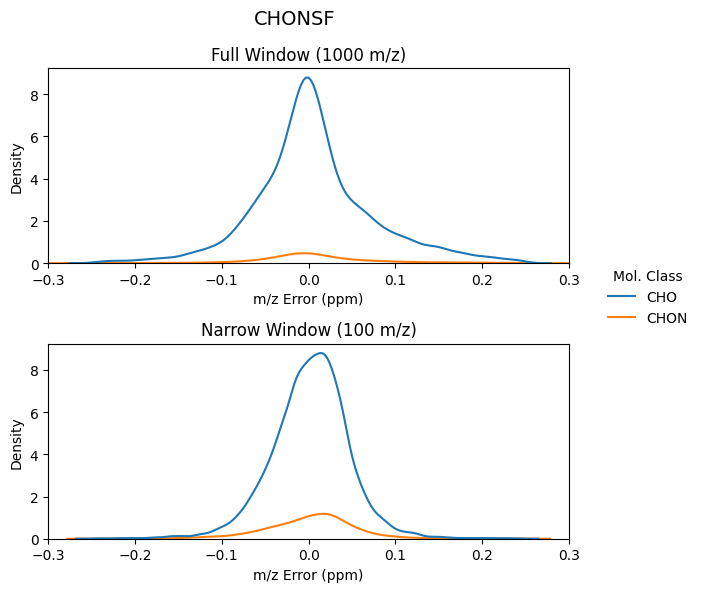

In [12]:
# plot assignment error kernel density CHON

ttt = 'CHONSF'  ## title for main plot

dffull = mzfull[(mzfull['mol_class']=='CHO') | (mzfull['mol_class']=='CHON')]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (6,6))
sns.kdeplot(data=dffull[dffull['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax1)
ax1.set_xlim(-0.3,0.3)
ax1.set_title( 'Full Window (1000 m/z)')
legend = ax1.get_legend()
handles = legend.legendHandles
labels = dffull[dffull['mol_class']!='Unassigned']['mol_class'].unique()
legend.remove()

df100 = mz100[(mz100['mol_class']=='CHO') | (mz100['mol_class']=='CHON')]
sns.kdeplot(data=df100[df100['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax2, legend = False)
ax2.set_title( 'Narrow Window (100 m/z)')
ax2.set_xlim(-0.3,0.3)


fig.suptitle(ttt, fontsize=14)
fig.legend(handles, labels, title='Mol. Class', frameon = False, bbox_to_anchor=(1.0,0.5), loc = 'center left')

plt.tight_layout()

plt.show()


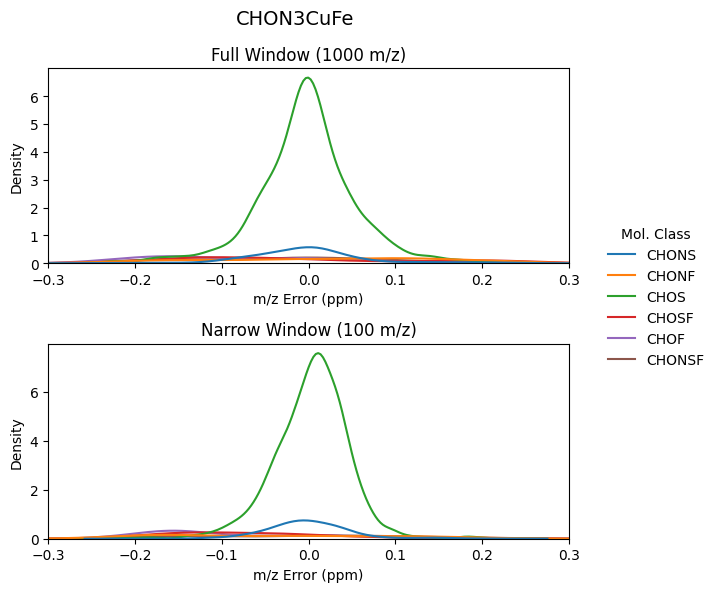

In [13]:
# plot assignment error kernel density CHON
import itertools
ttt = 'CHON3CuFe'  ## title for main plot

# set palette 
palette = itertools.cycle(sns.color_palette())



dffull = mzfull[(mzfull['mol_class']!='CHO') & (mzfull['mol_class']!='CHON')]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (6,6))
sns.kdeplot(data=dffull[dffull['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax1, palette=palette)
ax1.set_xlim(-0.3,0.3)
ax1.set_title( 'Full Window (1000 m/z)')
legend = ax1.get_legend()
handles = legend.legendHandles
labels = dffull[dffull['mol_class']!='Unassigned']['mol_class'].unique()
legend.remove()

palette = itertools.cycle(sns.color_palette())

df100 = mz100[(mz100['mol_class']!='CHO') & (mz100['mol_class']!='CHON')]
sns.kdeplot(data=df100[df100['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax2, legend = False, palette=palette)
ax2.set_title( 'Narrow Window (100 m/z)')
ax2.set_xlim(-0.3,0.3)

fig.suptitle(ttt, fontsize=14)
fig.legend(handles, labels, title='Mol. Class', frameon = False, bbox_to_anchor=(1.0,0.5), loc = 'center left')

plt.tight_layout()

plt.show()


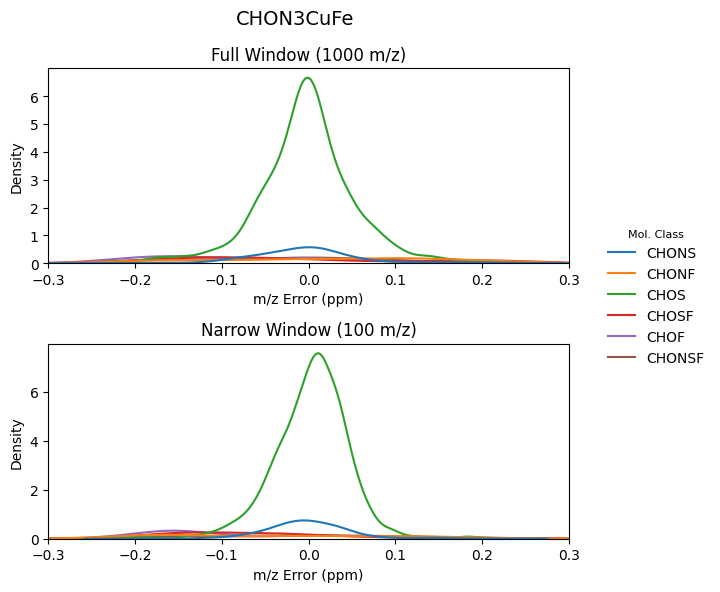

In [53]:
# plot assignment error kernel density CHON
import itertools
ttt = 'CHON3CuFe'  ## title for main plot

# set palette 
palette = itertools.cycle(sns.color_palette())

dffull = mzfull[(mzfull['mol_class']!='CHO') & (mzfull['mol_class']!='CHON')]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (6,6))
sns.kdeplot(data=dffull[dffull['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax1, palette=palette)
ax1.set_xlim(-0.3,0.3)
ax1.set_title( 'Full Window (1000 m/z)')
legend = ax1.get_legend()
handles = legend.legendHandles
labels = dffull[dffull['mol_class']!='Unassigned']['mol_class'].unique()
legend.remove()

palette = itertools.cycle(sns.color_palette())

df100 = mz100[(mz100['mol_class']!='CHO') & (mz100['mol_class']!='CHON')]
sns.kdeplot(data=df100[df100['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax2, legend = False, palette=palette)
ax2.set_title( 'Narrow Window (100 m/z)')
ax2.set_xlim(-0.3,0.3)

fig.suptitle(ttt, fontsize=14)
fig.legend(handles, labels, title='Mol. Class', frameon = False, bbox_to_anchor=(1.0,0.5), loc = 'center left')

plt.tight_layout()

plt.show()


In [14]:
# create subsets of assigned features 
assigned_100mz = mz100[~mz100['Molecular Formula'].isnull()]
assigned_fullmz = mzfull[~mzfull['Molecular Formula'].isnull()]

print('400-700 m/z, 100 m/z windowing: \n%s features total; %s assigned (%.1f%%)' %(np.shape(mz100)[0],  np.shape(assigned_100mz)[0], np.shape(assigned_100mz)[0] / np.shape(mz100)[0] * 100))
print('\n200-800 m/z window (full scan): \n%s features total; %s assigned (%.1f%%)' %(np.shape(mzfull)[0],np.shape(assigned_fullmz)[0],  np.shape(assigned_fullmz)[0] / np.shape(mzfull)[0] * 100))

400-700 m/z, 100 m/z windowing: 
32095 features total; 28733 assigned (89.5%)

200-800 m/z window (full scan): 
28928 features total; 25112 assigned (86.8%)


In [15]:
# create subsets of unique features 
print('400-700 m/z, 100 m/z windowing:')
unique_100mz = lcmsfns.getUniqueFeatures(assigned_100mz)

print('\n200-800 m/z, 1000 m/z windowing:')
unique_fullmz = lcmsfns.getUniqueFeatures(assigned_fullmz)


400-700 m/z, 100 m/z windowing:

200-800 m/z, 1000 m/z windowing:


In [16]:
# subset assigned by m/z window between 400 and 700 m/z 
assigned_100mz_456 = assigned_100mz[(assigned_100mz['m/z']>=300)]
assigned_100mz_456 = assigned_100mz_456[(assigned_100mz_456['m/z']<=500)]

assigned_fullmz_456 = assigned_fullmz[(assigned_fullmz['m/z']>=300)]
assigned_fullmz_456 = assigned_fullmz_456[(assigned_fullmz_456['m/z']<=500)]

mz100_456 = mz100[(mz100['m/z']>=300)]
mz100_456 = mz100_456[(mz100_456['m/z']<=500)]

mzfull_456 = mzfull[(mzfull['m/z']>=300)]
mzfull_456 = mzfull_456[(mzfull_456['m/z']<=500)]

print('400-700 m/z, 100 m/z windowing: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mz100_456)[0],  np.shape(assigned_100mz_456)[0], np.shape(assigned_100mz_456)[0] / np.shape(mz100_456)[0] * 100))
print('\n400-700 m/z, full window: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mzfull_456)[0],np.shape(assigned_fullmz_456)[0],  np.shape(assigned_fullmz_456)[0] / np.shape(mzfull_456)[0] * 100))


400-700 m/z, 100 m/z windowing: 
32095 features total
28733 assigned (89.5%)

400-700 m/z, full window: 
17288 features total
15717 assigned (90.9%)


In [17]:
print('400-700 m/z, 100 m/z windowing:')
unique_100mz_456 = lcmsfns.getUniqueFeatures(assigned_100mz_456)

print('\n400-700 m/z, 1000 m/z windowing:')
unique_fullmz_456 = lcmsfns.getUniqueFeatures(assigned_fullmz_456)

400-700 m/z, 100 m/z windowing:

400-700 m/z, 1000 m/z windowing:


In [18]:
import matplotlib.gridspec as gridspec

mz100_bs = unique_100mz_456# lcmsfns.blankSubtract(unique_100mz, blnkthresh = 0.6)
mzfull_bs = unique_fullmz_456 #lcmsfns.blankSubtract(unique_fullmz, blnkthresh = 0.6)

mzfull_bs_456 = mzfull_bs[(mzfull_bs['Calibrated m/z']>=300) & (mzfull_bs['Calibrated m/z']<=500)]
combo = pd.concat([mz100_bs, mzfull_bs_456], ignore_index=True)


for i in range(len(combo['m/z window'])):

    w = combo['m/z window'].iloc[i]

    if (w == '300-500 m/z') :
        
        combo['m/z Window Size'].iloc[i] = '200 m/z'

    elif (w == '200-1200 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '1000 m/z'

print(combo['m/z Window Size'].unique())


mzfull_456 = mzfull[(mzfull['Calibrated m/z']>=300) & (mzfull['Calibrated m/z']<=500)]
combo2 = pd.concat([mz100, mzfull_456], ignore_index=True)

for i in range(len(combo['m/z window'])):

    w = combo2['m/z window'].iloc[i]

    if (w == '300-500 m/z') :
        
        combo2['m/z Window Size'].iloc[i] = '200 m/z'

    elif (w == '200-1200 m/z'):
        
        combo2['m/z Window Size'].iloc[i] = '1000 m/z'

print(np.shape(combo),np.shape(combo2))


['200 m/z' '1000 m/z']
(13850, 53) (49383, 40)


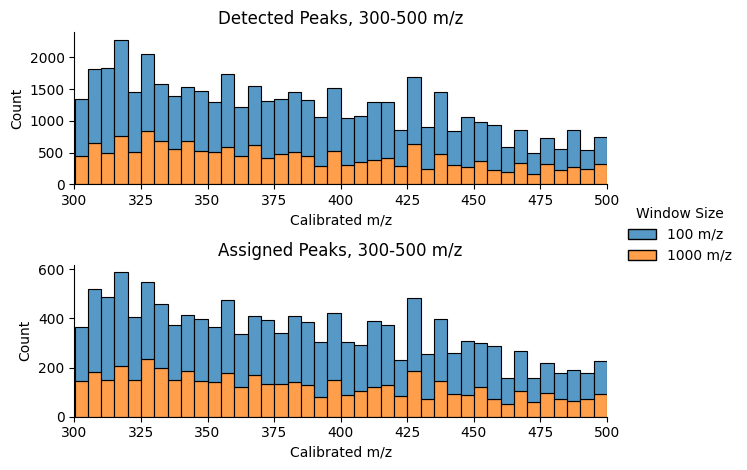

In [19]:

import matplotlib.gridspec as gridspec

#fig, (ax1_t,ax1_b, ax2) = plt.subplots(nrows=3, ncols=1, sharex = True, gridspec_kw={'hspace':0.02})
plt.subplots_adjust(hspace=0.3)
#make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1]) 
#make nested gridspecs
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])


ax1 = plt.subplot(gs2[0])

sns.histplot(combo, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax1,binwidth=5)
ax1.set_ylabel('Count')
ax1.legend_.remove()
ax1.set_xlim(300,500)
ax1.set_title('Assigned Peaks, 300-500 m/z')
#ax1.set_ylim(0,4500)

sns.despine(ax=ax1)


ax2 = plt.subplot(gs1[0])

sns.despine(ax=ax2)

sns.histplot(combo2, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax2,binwidth=5)
ax2.set_ylabel('Count')
ax2.set_xlim(300,500)
#ax2.set_ylim(0,4500)
ax2.set_title('Detected Peaks, 300-500 m/z')
legend = ax2.get_legend()
handles = legend.legendHandles
labels = ['100 m/z','1000 m/z']
ax2.legend_.remove()

fig = plt.gcf()

fig.legend(handles, labels, bbox_to_anchor=(0.98, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size')

fig.tight_layout()
plt.show()

['CHO' 'CHON' 'CHONS' 'CHONF' 'CHOS' 'CHOSF' 'CHOF' 'CHONSF' 'Unassigned']


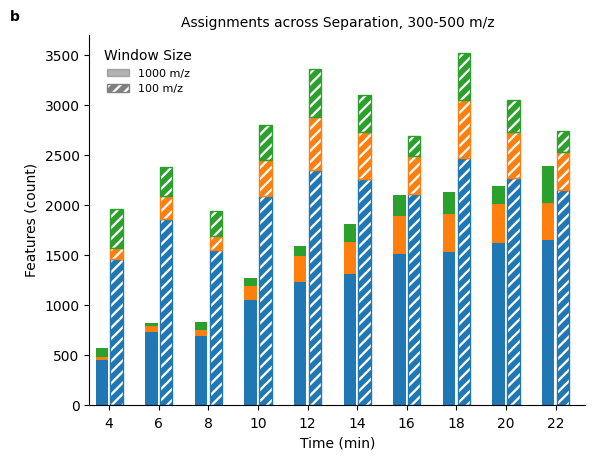

In [22]:
import matplotlib.patches as mpatches
fig, ax4 = plt.subplots()

all_results = pd.concat([mzfull[(mzfull['m/z']>=300) & (mzfull['m/z']<=500)],mz100[(mz100['m/z']>=300) & (mz100['m/z']<=500)]], ignore_index=True)

print(all_results['mol_class'].unique())
assign_summary=[]
for time in all_results['Time'].unique():    
    for w in all_results['m/z Window Size'].unique():
        current={}
        current['Time']=time
        current['m/z Window'] = w
        for mol_class in ['CHO','CHOS', 'Unassigned']:
            current[mol_class]=len(all_results[(all_results['mol_class']==mol_class) & (all_results['Time']==time) & (all_results['m/z Window Size']==w)])
        assign_summary.append(current)
df=pd.DataFrame(assign_summary)

df100 = df[df['m/z Window']=='100 m/z']

ax4 = df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
#ax4 = df100.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
plt.rcParams['hatch.linewidth'] = 4
n = 20
for i in range(n):
    new_x = ax4.patches[i].get_x() - ((i%2)/2)
    ax4.patches[i].set_x(new_x)
    ax4.patches[i+n].set_x(new_x)
    ax4.patches[i+(2*n)].set_x(new_x)

    if (i%2)/2 > 0:
        ax4.patches[i].set_x(new_x+0.1)
        ax4.patches[i+n].set_x(new_x+0.1)
        ax4.patches[i+(2*n)].set_x(new_x+0.1)

        ax4.patches[i].set_hatch('///')
        ax4.patches[i].set_edgecolor('C0')
        ax4.patches[i].set_fill(None)
        #ax4.patches[i].set_alpha(0.7)
        ax4.patches[i+n].set_hatch('///')
        ax4.patches[i+n].set_edgecolor('C1')
        ax4.patches[i+n].set_fill(None)
        #ax4.patches[i+(2*n)].set_alpha(0.7)
        ax4.patches[i+(2*n)].set_hatch('///')
        ax4.patches[i+(2*n)].set_edgecolor('C2')
        ax4.patches[i+(2*n)].set_fill(None)



# Update tick locations correspondingly
#minor_tick_locs = [x.get_x()+1/4 for x in ax4.patches[:28]]
major_tick_locs = np.array([x.get_x()+1/4 for x in ax4.patches[:int(n)]]).reshape(int(n/2), 2).mean(axis=1)
#ax4.set_xticks(minor_tick_locs, minor=True)
ax4.set_xticks(major_tick_locs)

# Use indices from dataframe as tick labels
major_tick_labels = df['Time'].unique()
#major_tick_labels = df_g.index.levels[0].values
#ax4.xaxis.set_ticklabels(minor_tick_labels, minor=True)
ax4.xaxis.set_ticklabels(major_tick_labels)

# Remove ticks and organize tick labels to avoid overlap
#ax4.tick_params(axis='x', which='both', bottom='off')
#ax4.tick_params(axis='x', which='minor', rotation=45)
ax4.tick_params(axis='x', which='major', pad=5, rotation=0)

ax4.set_xlabel('Time (min)')
ax4.set_ylabel('Features (count)')

leg = plt.legend(loc='center left', bbox_to_anchor=(1., 0.5), frameon=False, title='Mol. Class', prop={'size': 8})
ax4.add_artist(leg)
ax4.set_title('Assignments across Separation, 300-500 m/z',fontsize= 10)
a_val = 0.6

patch_full = mpatches.Patch(color='gray', alpha=a_val,label='1000 m/z')
patch_100 = mpatches.Patch(edgecolor='gray', facecolor = 'white', hatch = '///',label='100 m/z')



colors = ['#EA5739','#FEFFBE','#4BB05C']


#circ1 = mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=r'\\\\',label='Label1')
#circ2= mpatches.Patch( facecolor=colors[1],alpha=a_val,hatch='o',label='Label2')
#circ3 = mpatches.Patch(facecolor=colors[2],alpha=a_val,hatch='+',label='Label3')


plt.legend(handles=[patch_full, patch_100], loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon = False, title='Window Size', prop={'size': 8}) #.legend(handles = [circ1,circ2,circ3],loc=2)#.


sns.despine(ax=ax4)
ax4.text(-.15, 1.05,'b',
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax4.transAxes, fontweight='bold', fontsize = 10)
sns.despine(ax=ax4)

plt.show()


['CHO' 'CHON' 'CHONS' 'CHONF' 'CHOS' 'CHOSF' 'CHOF' 'CHONSF' 'Unassigned']


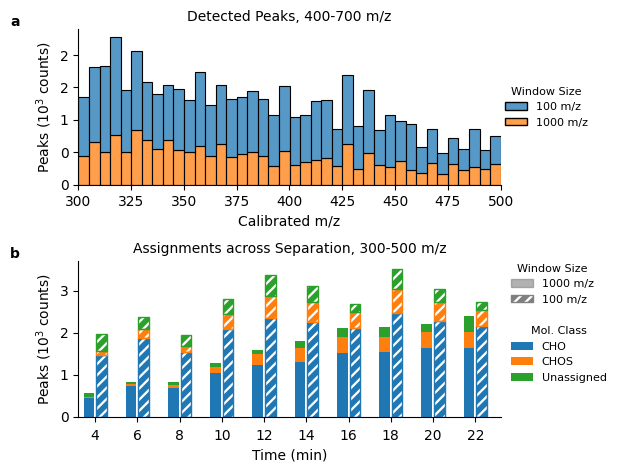

In [32]:
# histogram of features (a) and chromatogram of features (b)
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

#fig, (ax1_t,ax1_b, ax2) = plt.subplots(nrows=3, ncols=1, sharex = True, gridspec_kw={'hspace':0.02})
plt.subplots_adjust(hspace=0.3)
#make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1]) 
#make nested gridspecs
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])

plt.rcParams['legend.title_fontsize'] = 8


ax2 = plt.subplot(gs1[0])

sns.despine(ax=ax2)

sns.histplot(combo2, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax2,binwidth=5)
ax2.set_ylabel('Peaks ($10^3$ counts)')
ax2.set_xlim(300,500)
#ax2.set_ylim(0,4500)
legend = ax2.get_legend()
handles = legend.legendHandles
labels = ['100 m/z','1000 m/z']
ax2.set_title('Detected Peaks, 400-700 m/z', fontsize = 10)
#ax2.legend_.remove()

# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['%.0f' %(x/1000) for x in current_values])
fig = plt.gcf()

ax2.legend(handles, labels, bbox_to_anchor=(1.0, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size', prop={'size': 8})
ax2.text(-0.15, 1.05,'a',
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax2.transAxes, fontweight='bold', fontsize = 10)

ax4 = plt.subplot(gs2[0])


all_results = pd.concat([mzfull[(mzfull['m/z']>=300) & (mzfull['m/z']<=500)],mz100[(mz100['m/z']>=300) & (mz100['m/z']<=500)]], ignore_index=True)

print(all_results['mol_class'].unique())
assign_summary=[]
for time in all_results['Time'].unique():    
    for w in all_results['m/z Window Size'].unique():
        current={}
        current['Time']=time
        current['m/z Window'] = w
        for mol_class in ['CHO','CHOS', 'Unassigned']:
            current[mol_class]=len(all_results[(all_results['mol_class']==mol_class) & (all_results['Time']==time) & (all_results['m/z Window Size']==w)])
        assign_summary.append(current)
df=pd.DataFrame(assign_summary)

df100 = df[df['m/z Window']=='100 m/z']
ax4 = df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
#ax4 = df100.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
plt.rcParams['hatch.linewidth'] = 4
n = 20
for i in range(n):
    new_x = ax4.patches[i].get_x() - ((i%2)/2)
    ax4.patches[i].set_x(new_x)
    ax4.patches[i+n].set_x(new_x)
    ax4.patches[i+(2*n)].set_x(new_x)

    if (i%2)/2 > 0:
        ax4.patches[i].set_x(new_x+0.1)
        ax4.patches[i+n].set_x(new_x+0.1)
        ax4.patches[i+(2*n)].set_x(new_x+0.1)

        ax4.patches[i].set_hatch('///')
        ax4.patches[i].set_edgecolor('C0')
        ax4.patches[i].set_fill(None)
        #ax4.patches[i].set_alpha(0.7)
        ax4.patches[i+n].set_hatch('///')
        ax4.patches[i+n].set_edgecolor('C1')
        ax4.patches[i+n].set_fill(None)
        #ax4.patches[i+(2*n)].set_alpha(0.7)
        ax4.patches[i+(2*n)].set_hatch('///')
        ax4.patches[i+(2*n)].set_edgecolor('C2')
        ax4.patches[i+(2*n)].set_fill(None)



# Update tick locations correspondingly
#minor_tick_locs = [x.get_x()+1/4 for x in ax4.patches[:28]]
major_tick_locs = np.array([x.get_x()+1/4 for x in ax4.patches[:20]]).reshape(10, 2).mean(axis=1)
#ax4.set_xticks(minor_tick_locs, minor=True)
ax4.set_xticks(major_tick_locs)

# Use indices from dataframe as tick labels
major_tick_labels = df['Time'].unique()
#major_tick_labels = df_g.index.levels[0].values
#ax4.xaxis.set_ticklabels(minor_tick_labels, minor=True)
ax4.xaxis.set_ticklabels(major_tick_labels)

# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['%.0f' %(x/1000) for x in current_values])
# Remove ticks and organize tick labels to avoid overlap
#ax4.tick_params(axis='x', which='both', bottom='off')
#ax4.tick_params(axis='x', which='minor', rotation=45)
ax4.tick_params(axis='x', which='major', pad=5, rotation=0)

ax4.set_xlabel('Time (min)')
ax4.set_ylabel('Peaks ($10^3$ counts)')

ax4.legend(loc='center left', bbox_to_anchor=(1.0, 0.4), frameon=False, title='Mol. Class')

leg = plt.legend(loc='center left', bbox_to_anchor=(1., 0.4), frameon=False, title='Mol. Class', prop={'size': 8})
ax4.add_artist(leg)
ax4.set_title('Assignments across Separation, 300-500 m/z',fontsize= 10)
a_val = 0.6

patch_full = mpatches.Patch(color='gray', alpha=a_val,label='1000 m/z')
patch_100 = mpatches.Patch(edgecolor='gray', facecolor = 'white', hatch = '///',label='100 m/z')



colors = ['#EA5739','#FEFFBE','#4BB05C']


#circ1 = mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=r'\\\\',label='Label1')
#circ2= mpatches.Patch( facecolor=colors[1],alpha=a_val,hatch='o',label='Label2')
#circ3 = mpatches.Patch(facecolor=colors[2],alpha=a_val,hatch='+',label='Label3')


plt.legend(handles=[patch_full, patch_100], loc='upper left', bbox_to_anchor=(1, 1.05), frameon = False, title='Window Size', prop={'size': 8}) #.legend(handles = [circ1,circ2,circ3],loc=2)#.
sns.despine(ax=ax4)
ax4.text(-.15, 1.05,'b',
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax4.transAxes, fontweight='bold', fontsize = 10)
fig = plt.gcf()
fig.tight_layout(pad = 1.)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(435, 49) (249, 49)
here


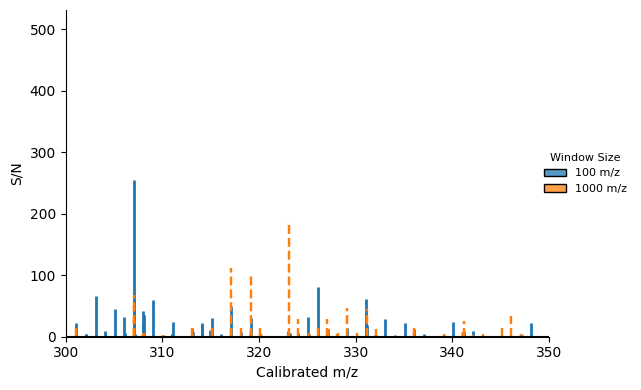

In [52]:
importlib.reload(icrms)
importlib.reload(lcmsfns)
import matplotlib.gridspec as gridspec



fig, ax2 = plt.subplots(figsize = (6.5,4))

mz100_bs = lcmsfns.blankSubtract(unique_100mz, blnkthresh = 0.6) #unique_100mz_456 #
mzfull_bs = lcmsfns.blankSubtract(unique_fullmz, blnkthresh = 0.6) #unique_fullmz_456 #

mzfull_bs_456 = mzfull_bs[(mzfull_bs['Calibrated m/z']>=300) & (mzfull_bs['Calibrated m/z']<=500)]

mz100_cu = mz100_bs[(mz100_bs['Calibrated m/z']>=300) & (mz100_bs['Calibrated m/z']<=500) ]

mz100_cu = mz100_cu[mz100_cu['F']>0]
mzfull_bs_456=mzfull_bs_456[mzfull_bs_456['F']>0]

d1=lcmsfns.normMS(mz100_cu, mz100_cu)
d2=lcmsfns.normMS(mzfull_bs_456,mzfull_bs_456)

#d1=mz100_bs[mz100_bs['Cu']>0]
#d2=mzfull_bs_456[mzfull_bs_456['Cu']>0]
print(np.shape(d1),  np.shape(d2))

ax2 = lcmsfns.plot_ms(df1=d1,  df2=d2, start_mz=300, end_mz=500,ax_ms=ax2, norm=False)

sns.despine(ax=ax2)

ax2.set_xlim(300,350)
ax2.set_ylim(bottom=0)
#ax2.set_title('S-Containing Features')
print('here')

ax2.legend(handles, labels, bbox_to_anchor=(0.98, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size', prop={'size': 8})

plt.tight_layout()
plt.show()

#(1738, 48) (1102, 48)

#(1646, 49) (1064, 49)

In [ ]:
df = mz100_cu
df = df[(df['m/z']<=600)& (df['m/z']>=400)]
df = df[df['Cu']>0]
df = df[df['file'].str.contains('Slough_ENV') ]

narrowmz = getEICs(df)

df2 = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<=600)]
df2 = df2[df2['Cu']>0]
df2 = df2[df2['file'].str.contains('Slough_ENV') ]

fullmz = getEICs(df2)


In [49]:



res = mz100_cu.loc[~mz100_cu['Molecular Formula'].isin(mzfull_bs_456['Molecular Formula'])] 
fullonly  = mzfull_bs_456.loc[~mzfull_bs_456['Molecular Formula'].isin(mz100_cu['Molecular Formula'])] 

res = res[res['file'].str.contains('FinalEff')]
fullonly = fullonly[fullonly['file'].str.contains('FinalEff')]

print(np.shape(res), np.shape(fullonly))

(154, 49) (18, 49)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1646, 49) (1064, 49)
here


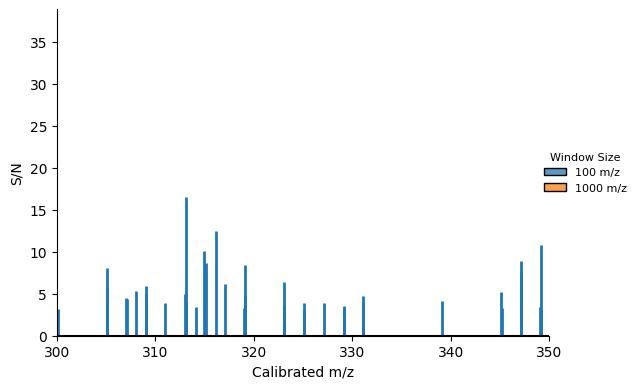

In [51]:
importlib.reload(icrms)
importlib.reload(lcmsfns)
import matplotlib.gridspec as gridspec



fig, ax2 = plt.subplots(figsize = (6.5,4))

mz100_bs = lcmsfns.blankSubtract(unique_100mz, blnkthresh = 0.6) #unique_100mz_456 #
mzfull_bs = lcmsfns.blankSubtract(unique_fullmz, blnkthresh = 0.6) #unique_fullmz_456 #

mzfull_bs_456 = mzfull_bs[(mzfull_bs['Calibrated m/z']>=300) & (mzfull_bs['Calibrated m/z']<=500)]

mz100_cu = mz100_bs[(mz100_bs['Calibrated m/z']>=300) & (mz100_bs['Calibrated m/z']<=500) ]

mz100_cu = mz100_cu[mz100_cu['S']>0]
mzfull_bs_456=mzfull_bs_456[mzfull_bs_456['S']>0]

d1=lcmsfns.normMS(mz100_cu, mz100_cu)
d2=lcmsfns.normMS(mzfull_bs_456,mzfull_bs_456)

#d1=mz100_bs[mz100_bs['Cu']>0]
#d2=mzfull_bs_456[mzfull_bs_456['Cu']>0]
print(np.shape(d1),  np.shape(d2))

ax2 = lcmsfns.plot_ms(df1=res,   start_mz=300, end_mz=500,ax_ms=ax2, norm=False)

sns.despine(ax=ax2)

ax2.set_xlim(300,350)
ax2.set_ylim(bottom=0)
#ax2.set_title('S-Containing Features')
print('here')

ax2.legend(handles, labels, bbox_to_anchor=(0.98, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size', prop={'size': 8})

plt.tight_layout()
plt.show()

#(1738, 48) (1102, 48)

#(1646, 49) (1064, 49)

(423, 49) (18, 49)


IndexError: list index out of range

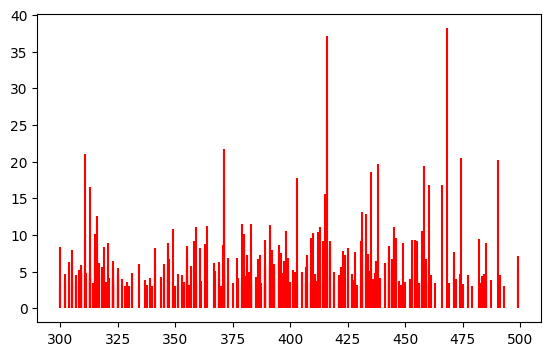

In [46]:
importlib.reload(icrms)
importlib.reload(lcmsfns)
import matplotlib.gridspec as gridspec


#res = mzfull_bs_456.loc[~mzfull_bs_456['Molecular Formula'].isin(mz100_cu['Molecular Formula'])] 

fig, ax2 = plt.subplots(figsize = (6.5,4))

mz100_bs = unique_100mz_456 #lcmsfns.blankSubtract(unique_100mz, blnkthresh = 0.6)
mzfull_bs = unique_fullmz_456 #lcmsfns.blankSubtract(unique_fullmz, blnkthresh = 0.6)

mzfull_bs_456 = mzfull_bs[(mzfull_bs['Calibrated m/z']>=300) & (mzfull_bs['Calibrated m/z']<=500)]

mz100_cu = mz100_bs[(mz100_bs['Calibrated m/z']>=300) & (mz100_bs['Calibrated m/z']<=500) ]

d2=lcmsfns.normMS(fullonly[fullonly['S']>0],fullonly[fullonly['S']>0])
d1=lcmsfns.normMS(res[res['S']>0],res[res['S']>0])

#d1=mz100_bs[mz100_bs['Cu']>0]
#d2=mzfull_bs_456[mzfull_bs_456['Cu']>0]
print(np.shape(d1),  np.shape(d2))

ax2 = lcmsfns.plot_ms(df1=d1, df2=d2,  start_mz=300, end_mz=500,ax_ms=ax2, norm=False, colors = ['red'])

sns.despine(ax=ax2)

ax2.set_xlim(300,350)
ax2.set_ylim(bottom=0)

print('here')

#ax2.legend(box_to_anchor=(0.98, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size', prop={'size': 8})

plt.tight_layout()
plt.show()

In [ ]:
# 100 m/z window, error plots with blank substraction

importlib.reload(icrms)
importlib.reload(lcmsfns)
df = unique_100mz#lcmsfns.blankSubtract(unique_100mz, blnkthresh = 0.6)
print(np.shape(unique_100mz))
print(np.shape(df))
fig = lcmsfns.plotUnique(df,ps=10)

fig.suptitle('100 m/z window, '+ttt, fontsize=14)

fig.set_size_inches(8,9)
plt.tight_layout()

plt.show()